# P-MOPSS: Pipeline for Magellan Optical Planetary Spectra Survey #

IMPORTANT -- before you run any code, make sure to create you save directory that you name below!

UNDER CONSTRUCTION. Will allow all reduction to be run from this notebook!


In [1]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *
from FullFrame import FullFrame

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##

##################
###   WASP4b   ###
##################
#obs_date='ut20150819'                           #observation date
#obj_name='Wasp4'                                #object name   
#midtime=['2015-08-19T07:43:00.00']                 #time of midtransit, WAsp-4b

#obj_skip=[2,6,9]
#binnx=1
#binny=1

###################
###   WASP52b   ###
###################
#obs_date='ut20160811'
#obs_date='ut20160922'
#obj_name='Wasp52'

#midtime=['2016-08-11T04:51:00']               #time of midtransit, Wasp-52b, Transit1
#midtime=['2016-09-22T04:44:00']               #time of midtransit, Wasp-52b, Transit2

#obj_skip=[1,4,6,7]
#binnx=1
#binny=1
#
##################
###   Hats8b   ###
##################
#obs_date='ut20170723'                           #observation date
#obs_date='ut20170828'
#obj_name='Hats8'                                #object name  

#midtime=['2017-07-24T05:28:01.056']                 #time of midtransit, Hats-8b, Transit 1
#midtime=['2017-08-29T01:36:04.608']                 #time of midtransit, Hats-8b Transit 2

#obj_skip=[]
#binnyx=1 (night 1)
#binny=1

#binnx=2  (night 2)
#binny=2

##################
### Wasp 67b  ###
##################
# obs_date='ut20180521'
# obj_name='Wasp67'
# midtime=['2018-05-22T06:54.00']

#obj_skip=[8,10]
#binnx=2
#binny=2

##################
###   WD1145   ###
##################
obs_date='ut20180521'                           #observation date

obj_name='WD1145'                                #object name   
midtime=['2018-05-21T23:00:00.00']                 #time of midtransit, WD1145

obj_skip=[10]
binnx=2
binny=2
###########################

path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
data_path=path+obj_name+'_Spec/'      #path to where your data is saved
flat_path=path+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS=path+obj_name+'_Darks/'     #path to where your darks are saved
FLATS=path+'Full_Flats/'             #path to where the full field flats are saved 
WAVE=path+obj_name+'_Arcs/'

#SAVEPATH='SaveData/'+obj_name+'/'
SAVEPATH=path+'SaveData_'+obj_name+'/'
#SAVEPATH='/Users/ermay/Desktop/Checking_Outliers_ML/'

wavelength_path=path+'WaveSolution'+obj_name+'/'

extray=600/binny #number of extra pixels to extract per side in y direction
extrax=80  #number on the side to find wavelength strip, only for nights with a single mask

#### CHECK BINNING IN SETUP.PY ####
#### if 1x1 binning, xpixels,ypixels should be 2048,4096
#### if 2x2 binning, xpixels,ypixels should be 1024,2048
print xpixels/binnx, ypixels/binny

1024 2048


# --------------------------------------------------------------------------- 
# The following cell extracts header information.

You can add arrays in HeaderData.py following the methods there. Certain values only need to be read out for 1 chip


In [7]:
## ------------------------------------------------------------- ##
## Run this block to read header and save relevant information.  ##
## REQUIRED for observation times and number                     ##
## ------------------------------------------------------------- ##
from HeaderData import *
ReadHeader(data_path,SAVEPATH)

## This cell only needs to be run ONCE. Will save to a .npz file you can read in for the arrays
## Keys in .npz file are the names of the arrays:
##'------------------------------------------'
##'   Observing Times: obs_times[n_exp]'
##'   Object Airmass:  airmass[n_exp]'
##'   Read Noise:      elc_noise[chip]'
##'   CCD Temperature: ccd_temp[chip,n_exp]'
##'   Structure Temp:  stc_temp[chip_n_exp]'
##'   Ion Pump Press:  ion_pump[chip_n_exp]'
##'------------------------------------------'

## NOTES:
##  This cell can take a few minutes to run. I'm working on speeding up the header reading process

0 %


KeyboardInterrupt: 

In [ ]:
import astropy
from astropy.time import Time

time_s=np.load(SAVEPATH+'HeaderData.npz')['obs_times']
time=Time(time_s,format='isot',scale='utc')
mid_transit=Time(midtime,format='isot',scale='utc')
time-=mid_transit
time0=np.zeros_like(time)*0.0
q=0
for i in time:
    time0[q]=np.float64(i.jd)
    q+=1
    
time0=time0.astype(float)
print len(time0)
    
np.savez_compressed(SAVEPATH+'Obs_times.npz',times=time0)
    

# --------------------------------------------------------------------------- 
# Master Dark and Flat Frames

Master Darks and Flats are first created by stitching together two chips in the vertical direction.

They are then combined into 'Full Frame' 8-chip Master Dark and Flats

In [4]:
## ------------------------------------------------------------- ##
##     make sure your paths are updated. (first cell)            ##
## ------------------------------------------------------------- ##

print 'Location of Darks is currently set to: ', DARKS
print 'Location of Flats is currently set to: ', FLATS
print ' '

from MasterFrame import MasterFrame

dark=MasterFrame(DARKS,'Darks',SAVEPATH,binn)                #first keyword=path, second keyword=save name
dark_full=FullFrame(1,dark,binn)                    #number of frames, matrix of double-chip images
del dark                                       #clearing memory


flat=MasterFrame(FLATS,'Flats',SAVEPATH,1)
flat_full=FullFrame(1,flat,1)
flat_full/=np.nanmedian(flat_full)

del flat

Location of Darks is currently set to:  /Volumes/ermay_ext/Magellan/ut20170723/Hats8_Darks/
Location of Flats is currently set to:  /Volumes/ermay_ext/Magellan/ut20170723/Full_Flats/
 
 
NUMBER OF ( Darks ) FRAMES:  3
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 
 
NUMBER OF ( Flats ) FRAMES:  3
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 


In [ ]:
##################################################################################
#####        Below: Plotting for sanity check ----                           #####
#####            if something doesn't look right, check your input locations #####
#####          (you can turn this off if you'd like, not the del commands)   #####
##################################################################################

levels_d=np.linspace(np.nanmin(dark_full[0,:,:]),np.nanmax(dark_full[0,:,:]),20)
levels_f=np.linspace(0,1.4,20)

fig,ax=plt.subplots(1,2,figsize=(16.,8.))
ax[0].contourf(dark_full[0,:,:],levels=levels_d,cmap=plt.cm.Greys_r)      
ax[0].set_title('Full Frame Darks')
if binn!=1:
    ax[1].contourf(binned_flat[:,:],levels=levels_f,cmap=plt.cm.Greys_r)
if binn==1:
    ax[1].contourf(flat_full[0,:,:],levels=levels_f,cmap=plt.cm.Greys_r)
ax[1].set_title('Full Frame Flats')

del dark_full
del flat_full

# --------------------------------------------------------------------------- 
# Creates Object Masks

(these are used to later only extract the parts of the data we want)

First: Objects are located using the flat_thres variable

Second: Vertical Chips are Stitched

Third: Horizontal Chips are Stitched

Fourth: Objects are Combined across Vertical Chips. 

 CHIP ALIGNMENT:
---------------------------------
|   6   |   5   |   8   |   7   |
---------------------------------
|   1   |   2   |   3   |   4   |
---------------------------------
 
------------------------------
 Working on chips 6 & 1
------------------------------
   -->>  DATA STITCHED


/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'linewidth'
  s)


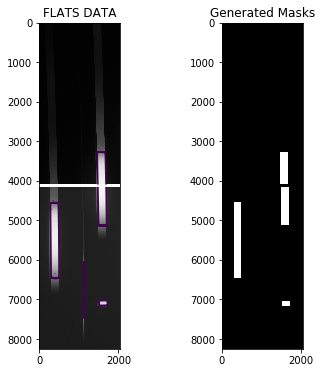

 
------------------------------
 Working on chips 5 & 2
------------------------------
   -->>  DATA STITCHED


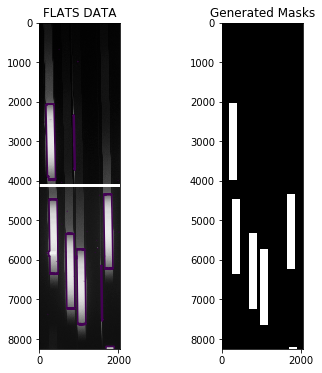

 
------------------------------
 Working on chips 8 & 3
------------------------------
   -->>  DATA STITCHED


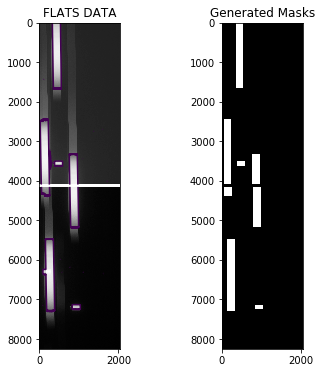

 
------------------------------
 Working on chips 7 & 4
------------------------------
   -->>  DATA STITCHED


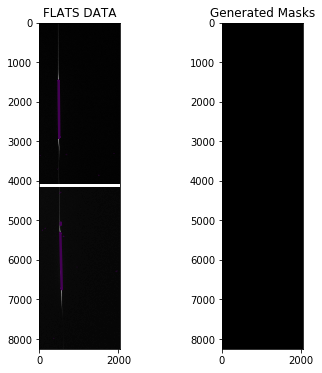

 -->> Combining Masks


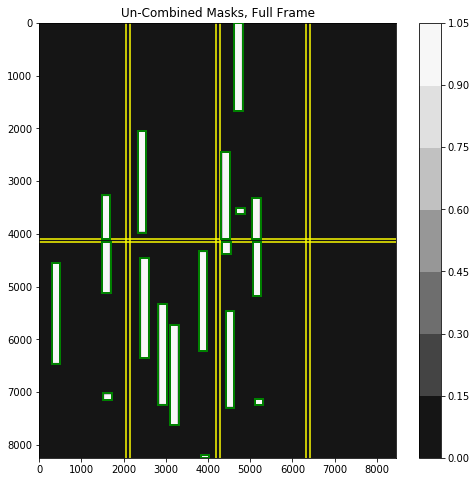

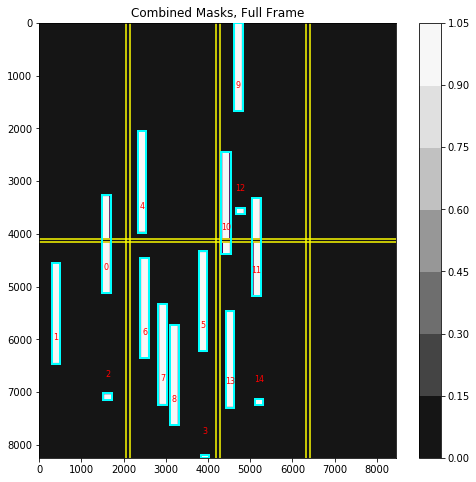

          (done)


In [14]:
## ------------------------------------------------------------- ##
## Masks are simply matrices of 1s and 0s                        ##
## ------------------------------------------------------------- ##

## user input needed:
#16 for wasp4
#34 for wasp52_1
#12 for wasp52_2
#6 for hats8_1
flat_root='ift0006c'         #root name of a slit flat image
flat_thres=4000.             #flat threshold: number of counts for 'edges' of masks.

#you may need to change the flat_thres value until you like the sizes of the extracted regions.

from FindMasks import FindMasks
from FindMasks import CombineMasks
#from FullFrame import FullFrame


masks=FindMasks(flat_path,flat_root,flat_thres,SAVEPATH,1,1)
mask_full=FullFrame(1,masks,1,1)
del masks

print' -->> Combining Masks'
mask_edges=CombineMasks(mask_full,SAVEPATH,1,1)
print'          (done)'

del mask_edges

# NOTES:
# I need to find a way to ignore 0th order boxes. These can be trimmed later, for now
# this will be updated to be dependent on the median level of counts found

## last plot is sometimes small? don't know why... double click to zoom 

# --------------------------------------------------------------------------- 
# Define Objects: Label Target and Remove 0th-order


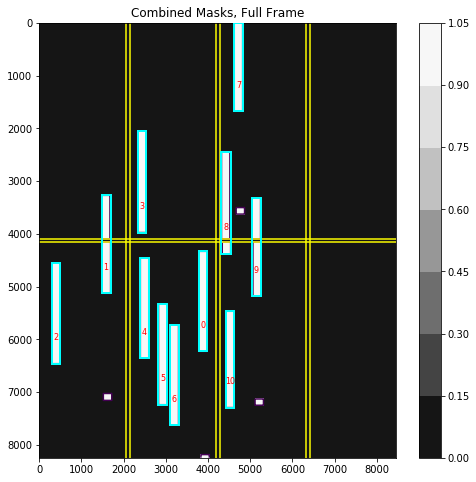

In [15]:
## ------------------------------------------------------------- ##
##  This rearranges masks so that the [0] element is the target  ##
##  zero-th order masks are also removed.                        ##
## ------------------------------------------------------------- ##

## using numbers output on combined mask image from cell above,define the following:
TAR=5                          #index for target
FIR=np.array([2,3,12,14])     #indices for zeroth order masks. These will be deleted


################## don't change below  ################
mask_edges=np.load(SAVEPATH+'CombinedMasks.npz')['mask_edges']
masks_fin=np.empty([mask_edges.shape[0]-len(FIR),mask_edges.shape[1]])*0.0

masks_fin[0,:]=mask_edges[TAR,:]
j=1
for i in range(0,mask_edges.shape[0]):
    if not i in FIR and i!=TAR:
        masks_fin[j,:]=mask_edges[i,:]
        j+=1
        
np.savez_compressed(SAVEPATH+'FinalMasks.npz',masks=masks_fin)

import matplotlib.patches as patches

y_arr_f=np.linspace(0,2*ypixels+ygap,2*ypixels+ygap)
x_arr_f=np.linspace(0,4*xpixels+3*xgap,4*xpixels+3*xgap)
X,Y=np.meshgrid(x_arr_f,y_arr_f)

fig1,ax1=plt.subplots(1,figsize=(8,8))
cs=ax1.contourf(X,Y,mask_full[0,:,:],cmap=plt.cm.Greys_r)
fig1.colorbar(cs,cmap=plt.cm.Greys_r)
cs=ax1.contour(X,Y,mask_full[0,:,:],levels=[0.99],color='red',linewidth=2.0)
ax1.set_ylim(2*ypixels/binny+ygap,0)
#### chip edges....
plt.axhline(y=ypixels/binny,color='yellow')
plt.axhline(y=ypixels/binny+ygap,color='yellow')
plt.axvline(x=xpixels/binnx,color='yellow')
plt.axvline(x=xpixels/binnx+xgap,color='yellow')
plt.axvline(x=2*xpixels/binnx+xgap,color='yellow')
plt.axvline(x=2*xpixels/binnx+2*xgap,color='yellow')
plt.axvline(x=3*xpixels/binnx+2*xgap,color='yellow')
plt.axvline(x=3*xpixels/binnx+3*xgap,color='yellow')
####
#paths=cs.collections[0].get_paths()
for i in range(masks_fin.shape[0]):
    x0,y0,x1,y1=masks_fin[i,0],masks_fin[i,1],masks_fin[i,2],masks_fin[i,3]
    ax1.add_patch(patches.Rectangle((x0,y0),np.abs(x0-x1),np.abs(y0-y1), facecolor='none', ec='cyan', linewidth=2, zorder=50))
    ax1.annotate(i,xy=(x0+100/binnx,y1-500/binny),ha='center',va='center',fontsize=8,color='red',zorder=51)
ax1.set_title('Combined Masks, Full Frame')
plt.show(block=False)

del masks_fin


# Extract Wavelength Calibration Data #

 -->> Loading Masks
          (done)


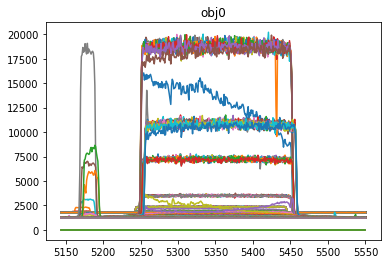

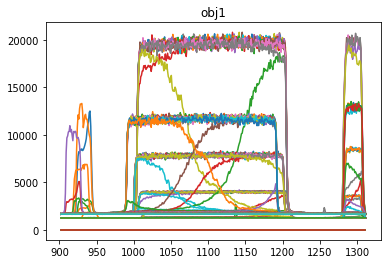

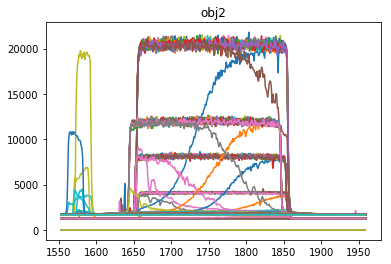

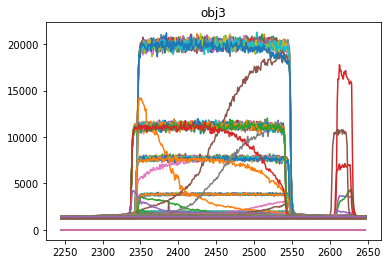

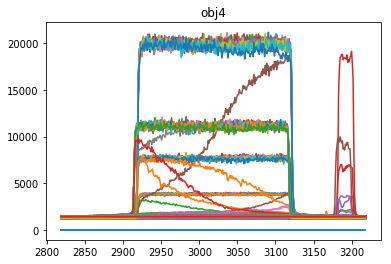

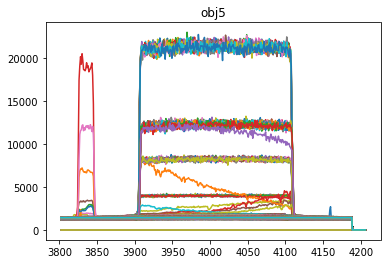

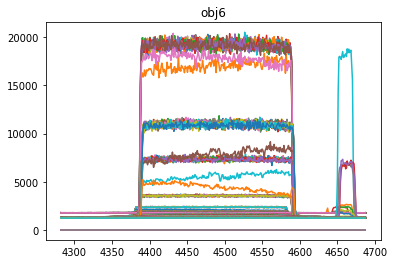

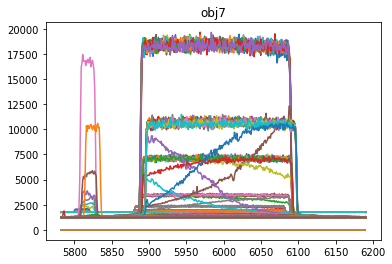

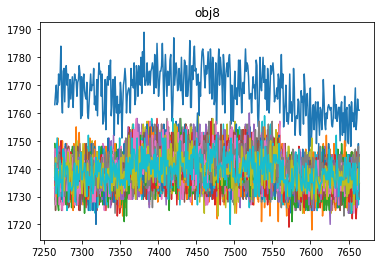

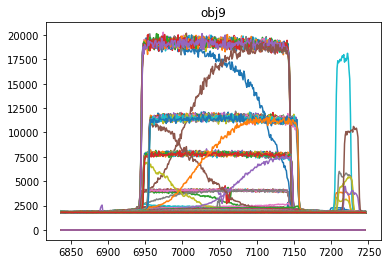

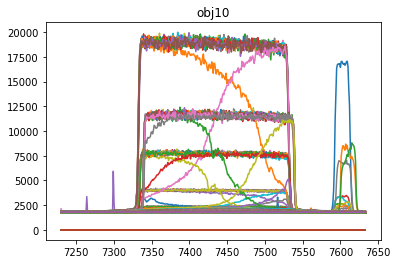

In [6]:
from WaveExtract import *

DetermineSide(5,path+obj_name+'_Arcs_He/',extray,100,SAVEPATH)

*************
  OBJECT  0
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


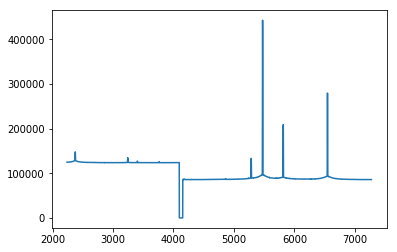

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


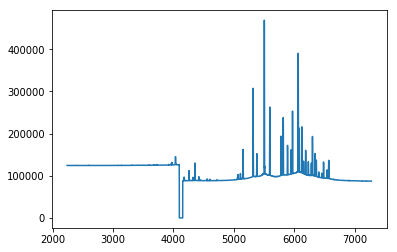

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


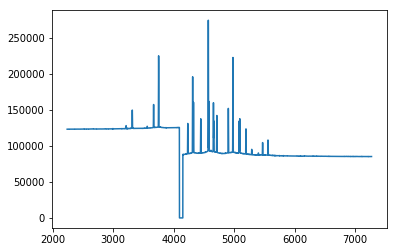

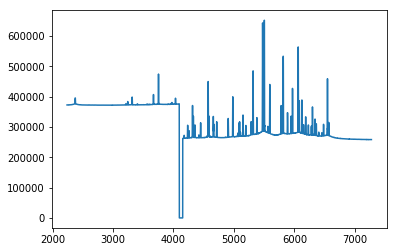

*************
  OBJECT  1
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


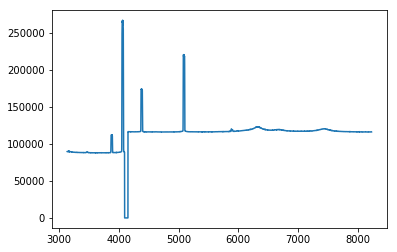

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


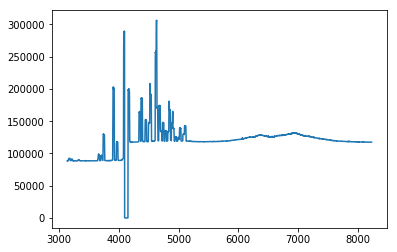

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


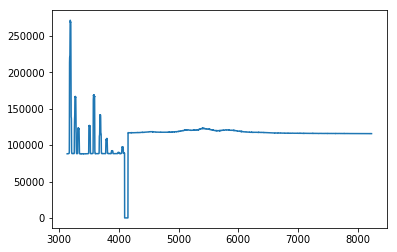

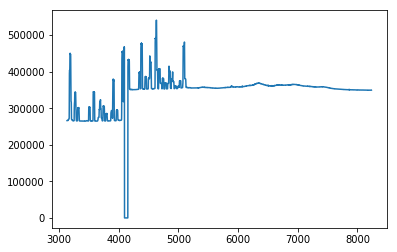

*************
  OBJECT  2
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


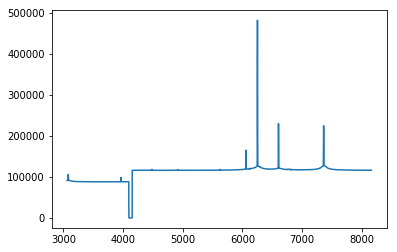

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


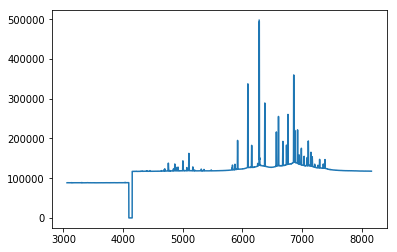

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


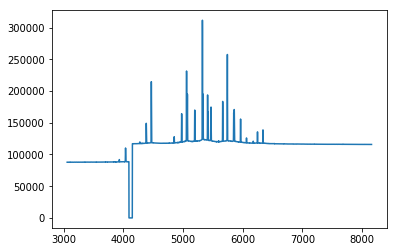

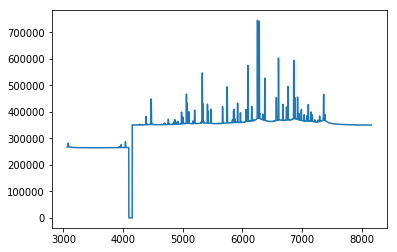

*************
  OBJECT  3
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


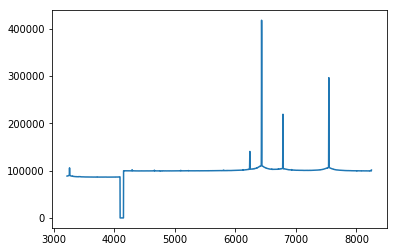

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


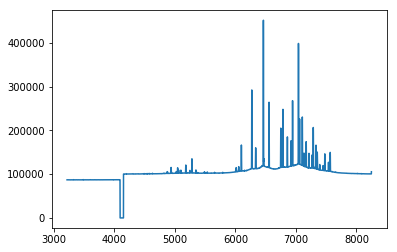

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


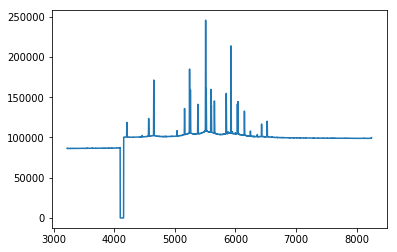

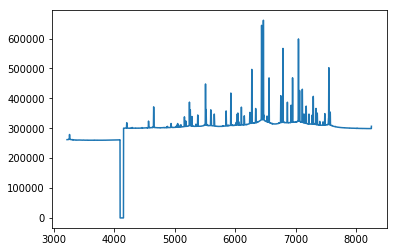

*************
  OBJECT  4
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


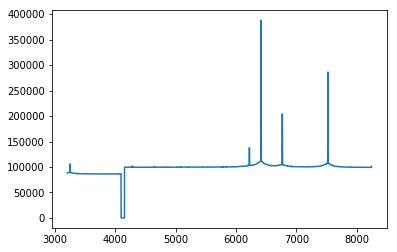

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


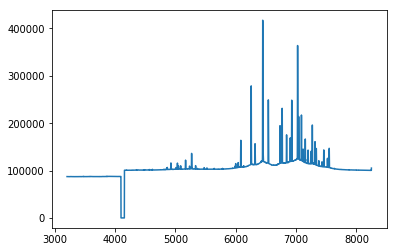

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


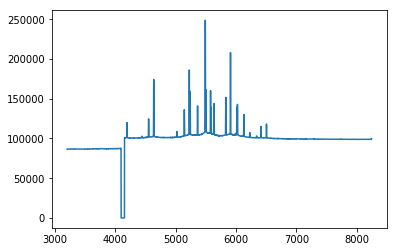

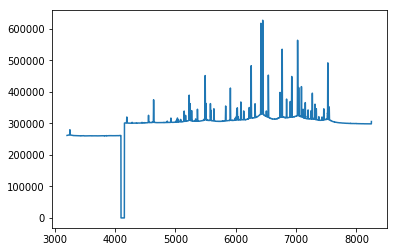

*************
  OBJECT  5
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


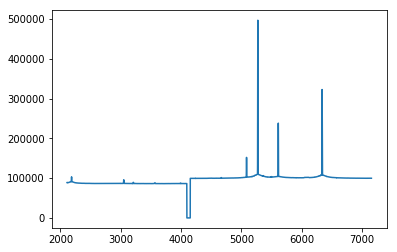

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


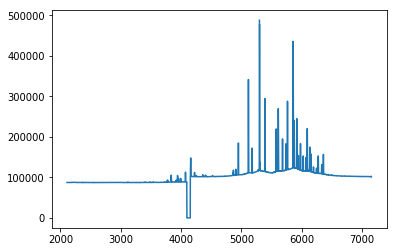

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


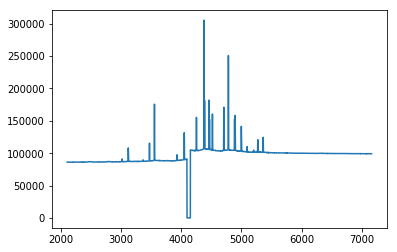

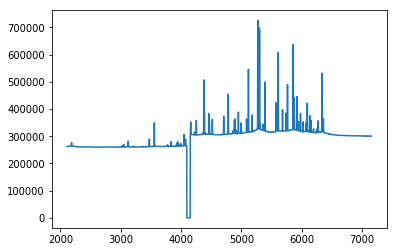

*************
  OBJECT  6
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


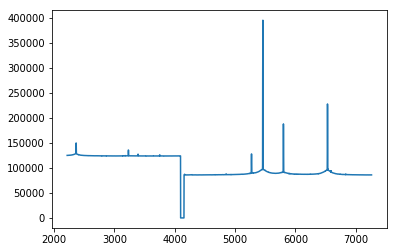

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


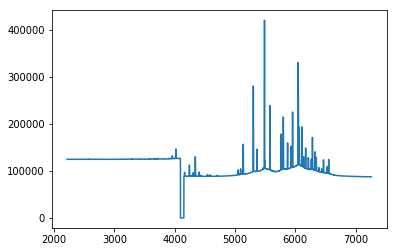

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


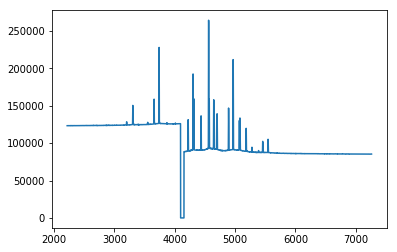

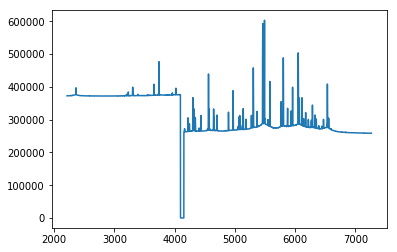

*************
  OBJECT  7
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


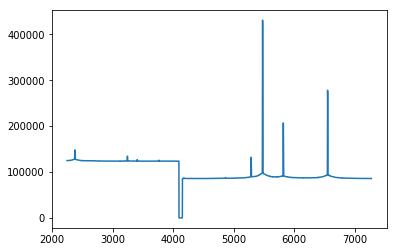

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


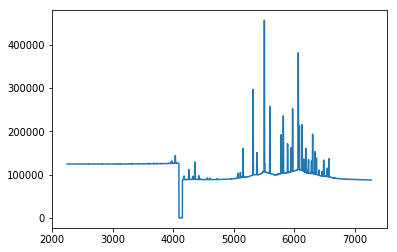

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


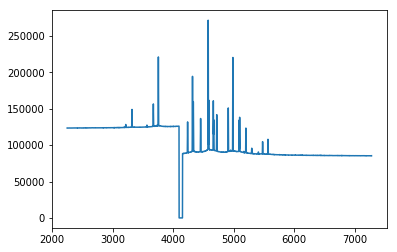

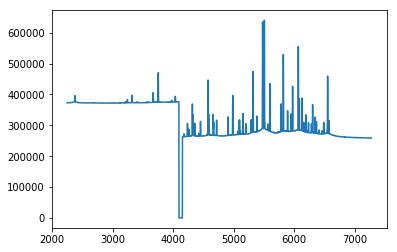

*************
  OBJECT  8
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


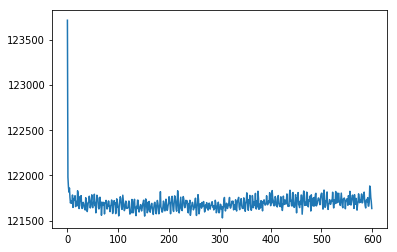

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


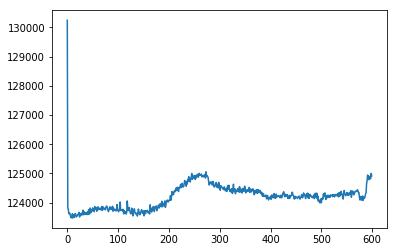

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


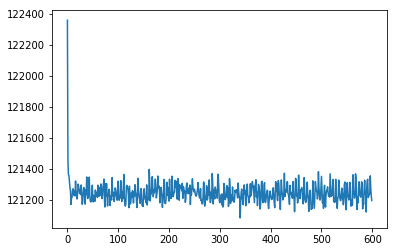

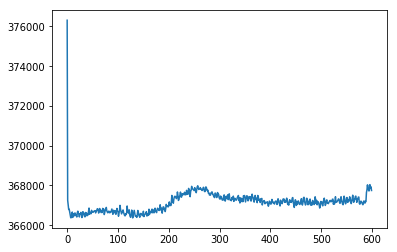

*************
  OBJECT  9
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


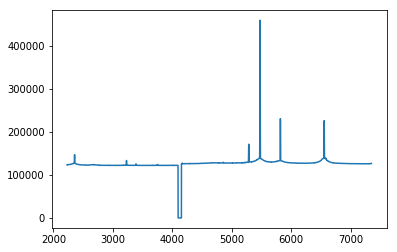

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


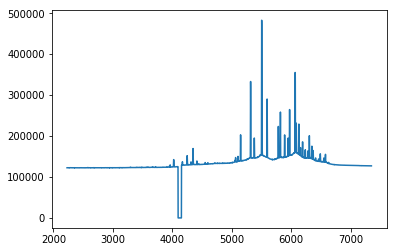

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


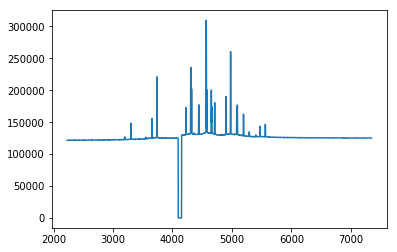

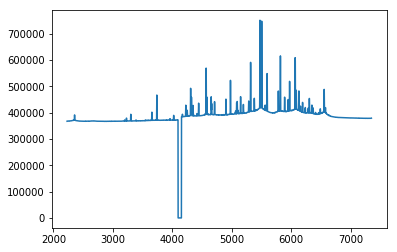

*************
  OBJECT  10
*************
-------------
He
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


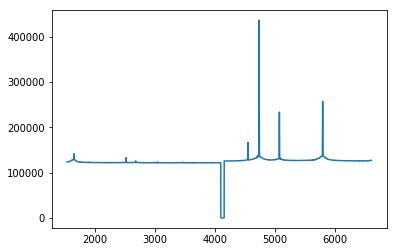

-------------
Ne
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


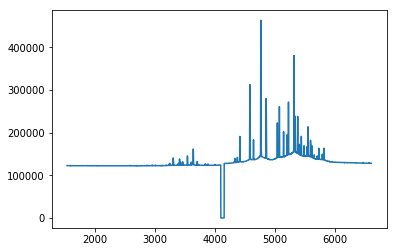

-------------
Ar
 -->> Loading Masks
          (done)
  -->> EXPOSURE #  1
  -->> EXPOSURE #  2
  -->> EXPOSURE #  3
  -->> EXPOSURE #  4
  -->> EXPOSURE #  5


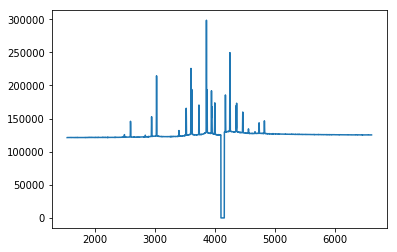

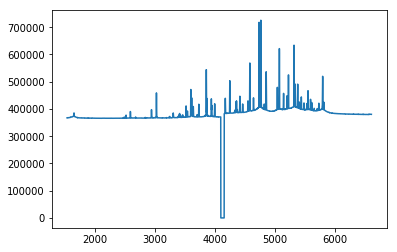

In [10]:
#side=['right','left','left','left','left','left','right','left','right', 'left','left']  #WD1145
side=['left','right','left','right','right','left','right','left','left','right','right']  #Wasp67b
elm=['He','Ne','Ar']
n_wave=5

for s in range(0,len(side)):
    spec=np.zeros_like(np.linspace(0,2*ypixels+ygap,2*ypixels+ygap))
    print '*************'
    print '  OBJECT ',s
    print '*************'
    for e in elm:
        print '-------------'
        print e
        if side[s]=='left':
            spec+=Extract_wave_left(path+obj_name+'_Arcs_'+e+'/',extray*binny,90,SAVEPATH,s,n_wave)
        if side[s]=='right':
            spec+=Extract_wave_right(path+obj_name+'_Arcs_'+e+'/',extray*binny,90,SAVEPATH,s,n_wave)
#        spec+=Extract_wave_center(path+obj_name+'_Arcs_'+e+'/',extray,extrax,SAVEPATH,s,n_wave)
            
    plt.figure(100)
    plt.clf()
    plt.plot(np.linspace(0,2*ypixels+ygap,2*ypixels+ygap),spec)
    plt.show()
    np.savez(SAVEPATH+'wavespec_obj'+str(int(s))+'.npz', spec=np.flip(spec,0))
        

# --------------------------------------------------------------------------- 
# Extract 2D Spectra for each Object #
Dark is subtracted, Flat is divided out.

In [2]:
from Extract2d import Extract2D

#extra=400                             #number of extra pixels to extract per side in y direction



Lflat=False                             #Logical switch to apply flats or not.
Ldark=False

bx=binnx #if your flats were in 2x2 binning, =1, otherwise= binnx
by=binny #if your flats were in 2x2 binning, =1, otherwise= binny
fb=1     # flat binning

data=Extract2D(data_path,extray,SAVEPATH,bx,by,fb,Lflat,Ldark)
del data

#output is a dictionary. Keys are formated as 'obj#', with 'obj0' being the target and 'obj1'+ being calibrators
#
#invalid value encountered in divide error - IGNORE. We are dividing full frame images which include NaNs for the gaps.

 -->> Loading Masks
          (done)
 -->> Loading HeaderData
               86
          (done)
           ( EXTRACTED DATA FOR IMAGE  10 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  20 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  30 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  40 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  50 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  60 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  70 )  --    86  exposures total
           ( EXTRACTED DATA FOR IMAGE  80 )  --    86  exposures total


# ----------------------------------
# Inputs for Background Subtraction and Flatten
## (should be the same for both functions)

In [2]:
Lflat=False                             #Logical switch to apply flats or not.
Ldark=False

ed_l=70/binnx#45#80/binn     #lower edge between background/data
ed_u=70/binnx#35#120/binn    #upper edge between background/data (width minus this value)

ed_t=30/binnx           #edges to trim

time_start=0
time_trim=0

# Background Subtraction 

-----------------
  OBJECT #  6
-----------------
 ----> loading data...
      (done)
 ----> loading masks...
      (done)
6 1552 2590
       *** TIME:  0  ***


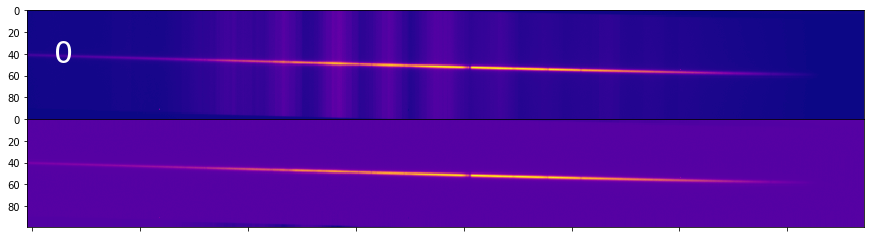

       *** TIME:  10  ***


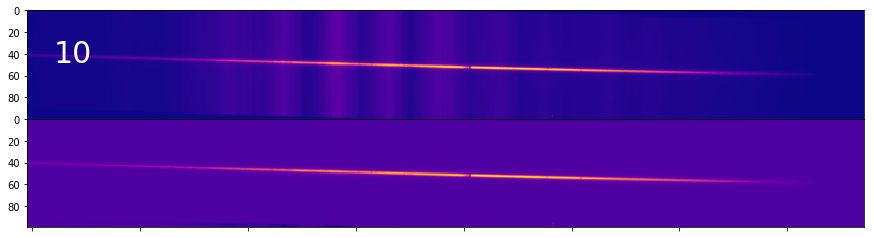

KeyboardInterrupt: 

In [3]:
from BackgroundSubtraction import BG_remove

ks_b=int((25-1)/binnx+1)#29             #kernel size for bakground outlier replacement. should be large (at least 15)
sig_b=3.               #sigma outlier threshold, background
o_b=2                  # order of polynomial fit to the data

ver=False               #Verbose output - LOTS OF PLOTS, BE WARNED. Useful for debugging and deciding on above parameters. 
ver_full=False         #plots that take a long time, moderately useful
ver_t=True             # plots the corrected 2D spectrum each exposure

trip=True              #if true, runs median filter three times.

obj_skip=[0,1,2,3,4,5]

BG_remove(extray,SAVEPATH,binnx,binny,Lflat,Ldark,ed_l,ed_u,ed_t,ks_b,sig_b,o_b,ver,ver_full,ver_t,trip,time_start,time_trim,obj_skip)

# Flatten 2D Spectra #

In [ ]:
from FlattenSpec import FlattenSpec
#extray,SAVEPATH,corr,ed_l,ed_u,ed_t,ks_b,ks_d,sig_b,sig_d,ver,data_corr

CON=False   #constant aperture 

ks_d=5 #7 for 1x1    #kernel size for data area outlier replacement. shoudl be small (default 7)
sig_d=5  #sigma outlier threshold, data. generally around 3.5, too low, too many flagged and vice versa

ks_s=5 #7 for 1x1   #kernel for spec
sig_s=3  #sig for spec

a_s=4    #aperture size (a_s*fwhm=aperture)
a_d=1    #inner app for corr
in_fwhm=4./binnx   #initial guess on fwhm

ver_full=False #Verbose output - LOTS OF PLOTS, BE WARNED  Useful for debugging and deciding on above parameters. 
ver_a=True  #plot x-aligned 2D specta
ver_t=True  #plot spectra
ver_x=True  #plot x-shift 
ver_w=False  #warning plots
ver=False  #plot second level corrections

data_corr=False    #corrections along data gauss

trip=True   #if true, runs median filter three times. (Use for data with high cloud coverage, or cosmic ray hits)


flat_spec=FlattenSpec(extray,SAVEPATH,ed_l,ed_u,binnx,binny,Lflat,Ldark,CON,ks_d,sig_d,ks_s,sig_s,in_fwhm,ver_full,ver_a,ver_t,ver_x,ver_w,ver,data_corr,trip,time_start,time_trim,obj_skip,a_s,a_d)



# --------------------------------------------------------------------------- 
# Time Correlation and Apply Wavelength Calibration #
This accounts for shifts in the spectral direction by oversampling the spectra by your given factor and cross correlating in time to dectect shifts down to (1/factor) of a pixel.

After correlation, all spectra are shifted as necessary and wavelength calibration is applied.

--> TO DO: make size of convolving gaussian vary according to the extracted FWHM.

-----------------
  OBJECT #  0
-----------------


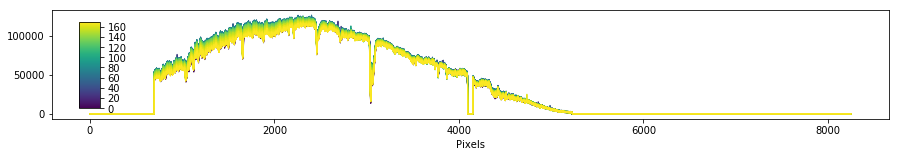

 --Filtering...
       -->> 204.141176471 34704


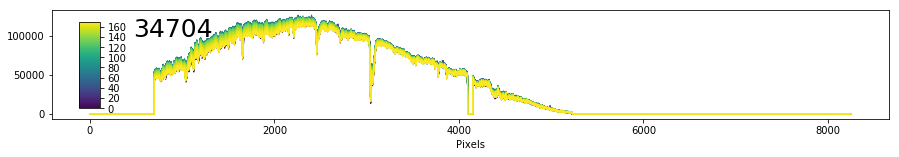

 --Convolving with Gaussian...


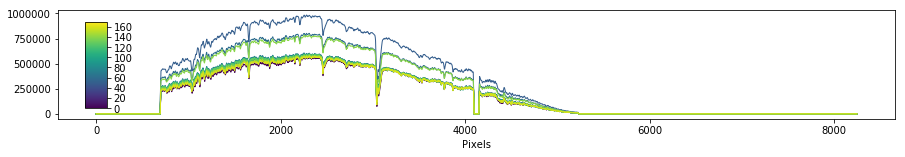

 --Oversampling...
 --Cross Correlating in Time...
518888 523627
576733 581559
601293 606175
656344 661390


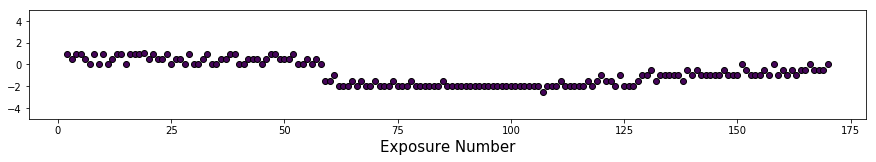

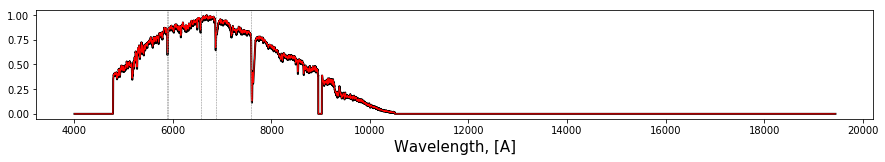

-----------------
  OBJECT #  1
-----------------
--------- BAD WAVELENGTH SOLUTION
-----------------
  OBJECT #  2
-----------------


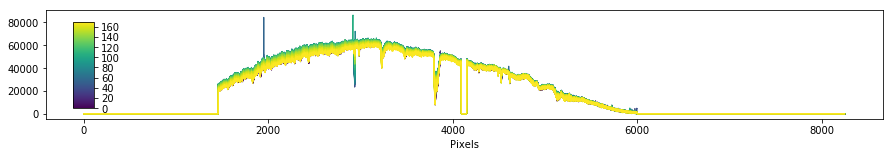

 --Filtering...
       -->> 171.229411765 29109


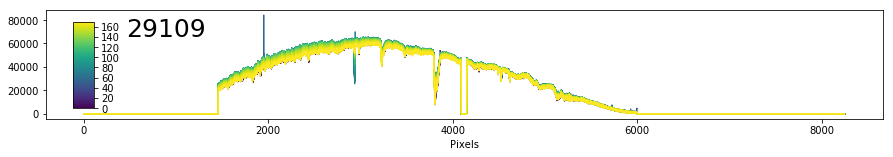

 --Convolving with Gaussian...


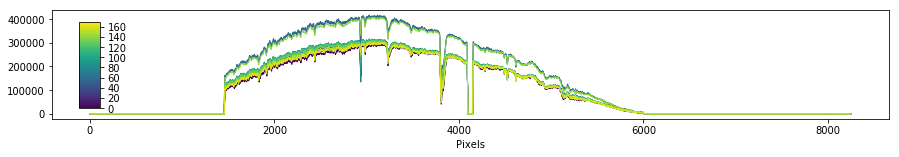

 --Oversampling...
 --Cross Correlating in Time...
441824 446485
499016 503807
523402 528248
577885 582852


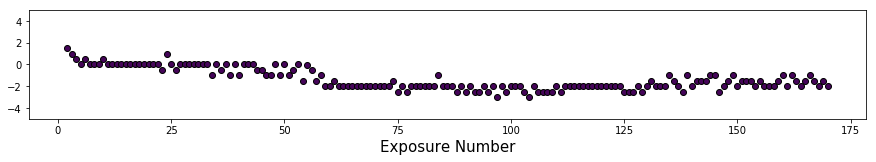

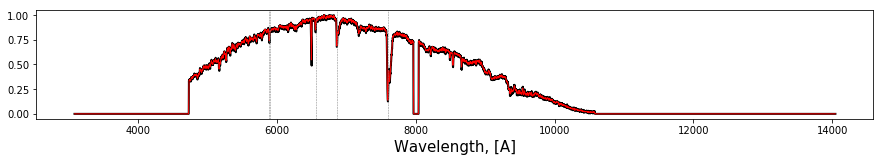

-----------------
  OBJECT #  3
-----------------


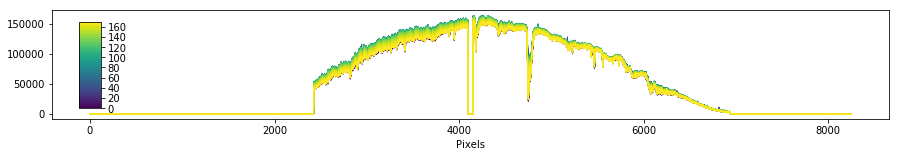

 --Filtering...
       -->> 198.776470588 33792


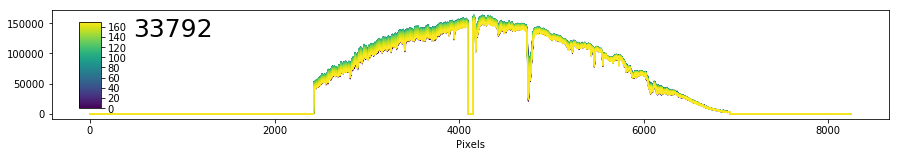

 --Convolving with Gaussian...


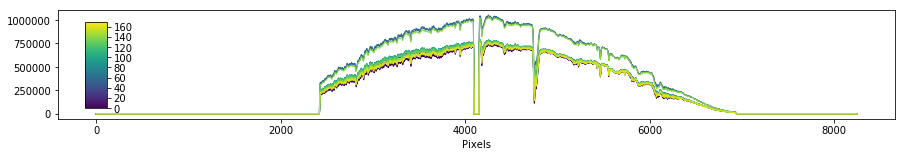

 --Oversampling...
 --Cross Correlating in Time...
348130 352808
404444 409068
427901 432546
480303 485134


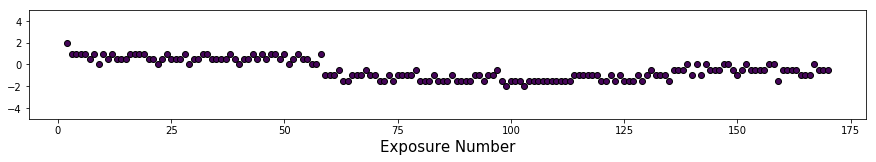

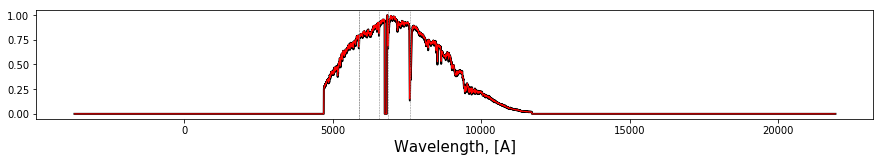

-----------------
  OBJECT #  4
-----------------
--------- BAD WAVELENGTH SOLUTION
-----------------
  OBJECT #  5
-----------------


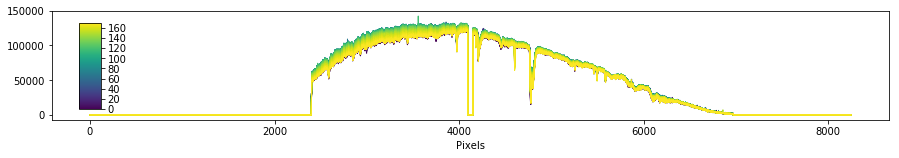

 --Filtering...
       -->> 129.323529412 21985


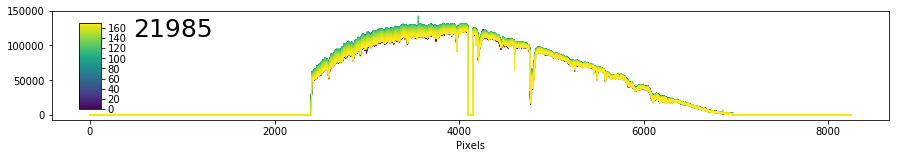

 --Convolving with Gaussian...


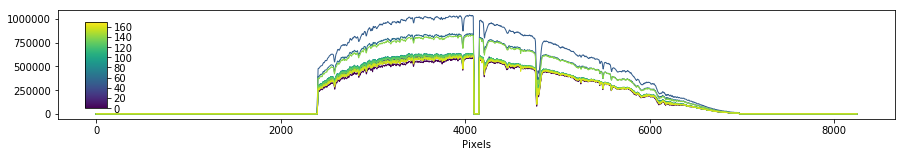

 --Oversampling...
 --Cross Correlating in Time...
344872 349467
400858 405518
424552 429255
477451 482286


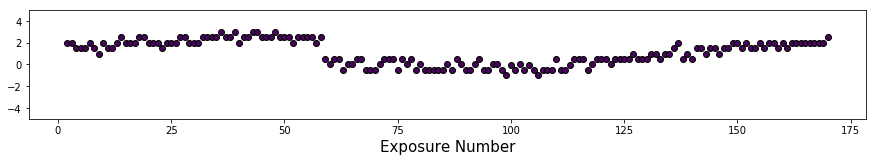

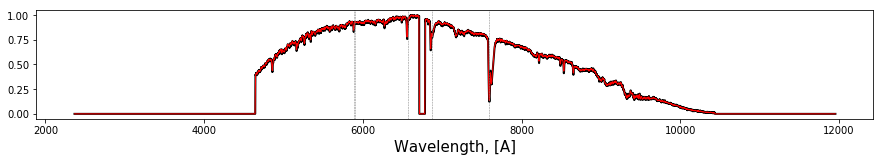

-----------------
  OBJECT #  6
-----------------
--------- BAD WAVELENGTH SOLUTION
-----------------
  OBJECT #  7
-----------------
--------- BAD WAVELENGTH SOLUTION
-----------------
  OBJECT #  8
-----------------


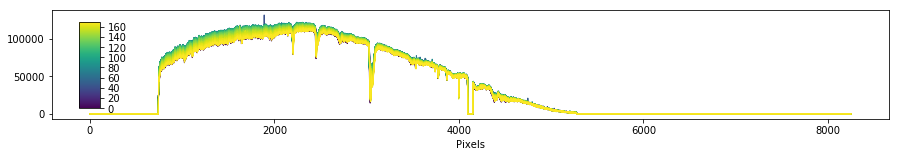

 --Filtering...
       -->> 56.0647058824 9531


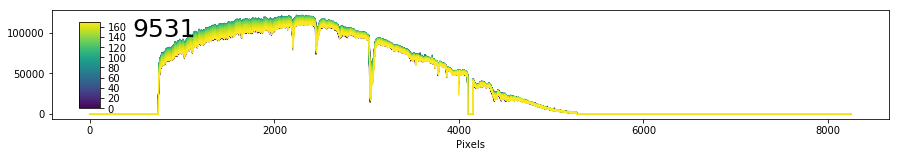

 --Convolving with Gaussian...


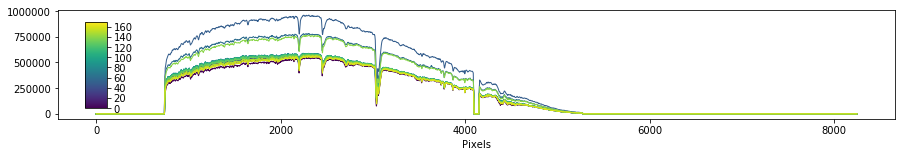

 --Oversampling...
 --Cross Correlating in Time...
519069 523829
577312 582180
602085 607008
657524 662595


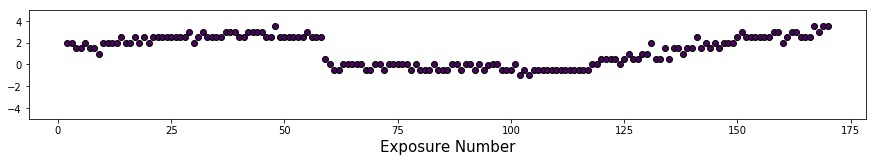

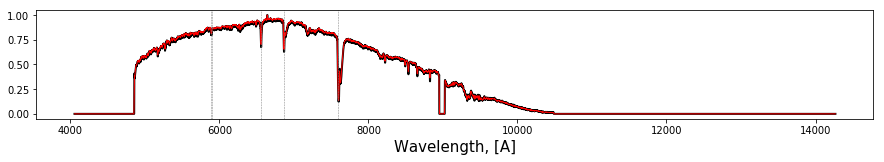

In [22]:
# to run this cell, you must have the wavelength solution text files
from AlignSpec import func_gaus
from AlignSpec import AlignSpec

gris=300  #lines/mm grism
osr=100.


fwhm_gauss=5                    #Convolving gaussian FWHM in pixels
                    #if next input is TRUE, uses FWHM from fits to determine convolution function

ks=7   #kernel size for smoothing of spectra to detect outliers
olv=3.

path0='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
wavelength_path0=path+'WaveSolution_'+obj_name+'/'


time_trim=0  # number of last exposures to ignore (6 for WASP4b)
ver=False   #verbose output toggle. plots lines used for y-shifts every 10 exposures.
ver_l=False  #prints line shift info every 10 exposures


Aligned=AlignSpec(gris,osr,fwhm_gauss,True,ks,olv,wavelength_path0,obj_name,SAVEPATH,extray,binny,ver,ver_l,time_trim,obj_skip)

del Aligned

# --------------------------------------------------------------------------- 
# Binning the Data

You can define the width of the bins here. 


8249
  -->> From Lambda= 4600  to Lambda= 8000
  -->> TOTAL OF  1 WAVELENGTH BINS
       Bin Centers:  [6300.]
       Bin Array:    [4600. 8000.]
       Bin Width:    3400
 
 >>>>>>>>>> OBJ:  0  <<<<<<<<<<
     -->> Summing up Wavelength Bins


/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


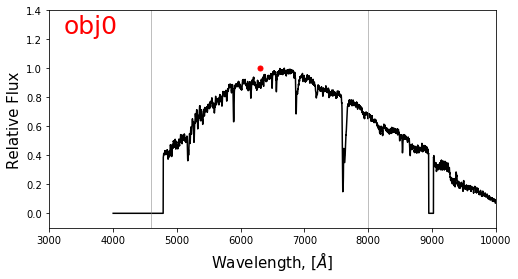

 
 >>>>>>>>>> OBJ:  1  <<<<<<<<<<
     -->> Summing up Wavelength Bins


Binning.py:130: RuntimeWarning: All-NaN slice encountered
  plt.plot(wav_arr[s,10,:],cnt_arr[s,10,:]/np.nanmax(cnt_arr[s,10,:]),color='black')
Binning.py:131: RuntimeWarning: All-NaN slice encountered
  plt.plot(bin_ctr,bin_cnt[10,:,s]/np.nanmax(bin_cnt[10,:,s]),'.',markersize=10,color='red')
Binning.py:132: RuntimeWarning: All-NaN slice encountered
  plt.errorbar(bin_ctr,bin_cnt[10,:,s]/np.nanmax(bin_cnt[10,:,s]),
Binning.py:133: RuntimeWarning: All-NaN slice encountered
  yerr=10*bin_err[10,:,s]/np.nanmax(bin_cnt[10,:,s]),fmt=None,ecolor='red')


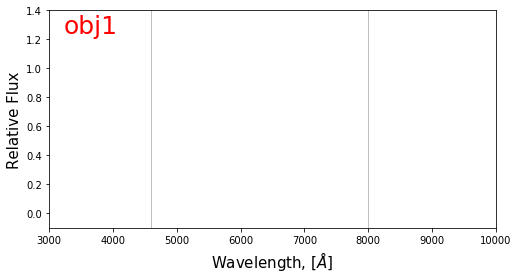

 
 >>>>>>>>>> OBJ:  2  <<<<<<<<<<
     -->> Summing up Wavelength Bins


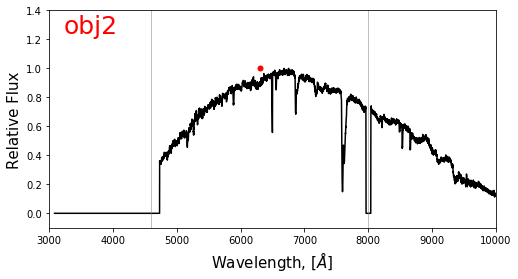

 
 >>>>>>>>>> OBJ:  3  <<<<<<<<<<
     -->> Summing up Wavelength Bins


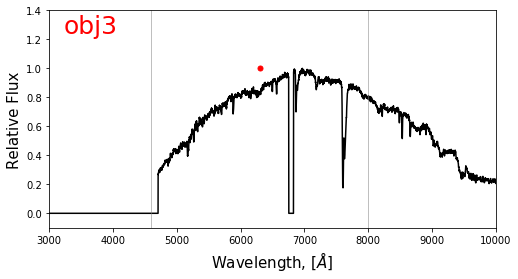

 
 >>>>>>>>>> OBJ:  4  <<<<<<<<<<
     -->> Summing up Wavelength Bins


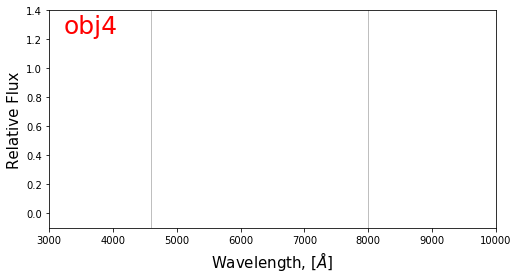

 
 >>>>>>>>>> OBJ:  5  <<<<<<<<<<
     -->> Summing up Wavelength Bins


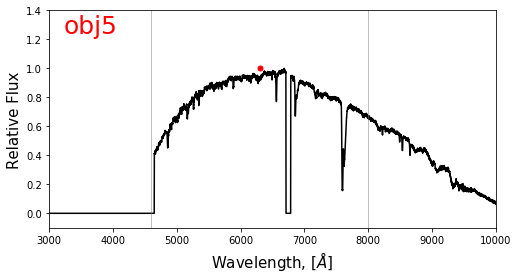

 
 >>>>>>>>>> OBJ:  6  <<<<<<<<<<
     -->> Summing up Wavelength Bins


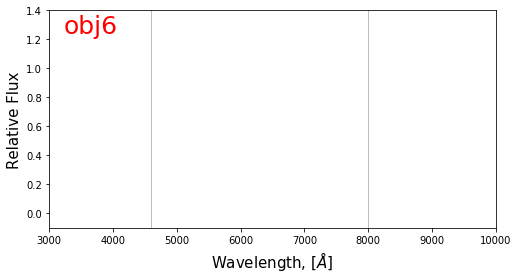

 
 >>>>>>>>>> OBJ:  7  <<<<<<<<<<
     -->> Summing up Wavelength Bins


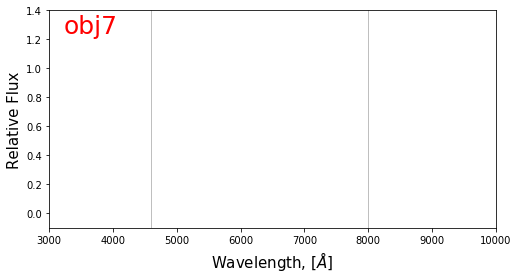

 
 >>>>>>>>>> OBJ:  8  <<<<<<<<<<
     -->> Summing up Wavelength Bins


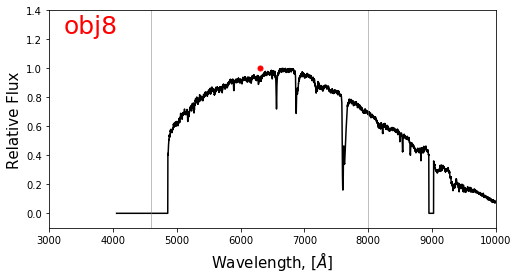

8249
  -->> From Lambda= 4600  to Lambda= 8000
  -->> TOTAL OF  17 WAVELENGTH BINS
       Bin Centers:  [4700. 4900. 5100. 5300. 5500. 5700. 5900. 6100. 6300. 6500. 6700. 6900.
 7100. 7300. 7500. 7700. 7900.]
       Bin Array:    [4600. 4800. 5000. 5200. 5400. 5600. 5800. 6000. 6200. 6400. 6600. 6800.
 7000. 7200. 7400. 7600. 7800. 8000.]
       Bin Width:    200
 
 >>>>>>>>>> OBJ:  0  <<<<<<<<<<
     -->> Summing up Wavelength Bins


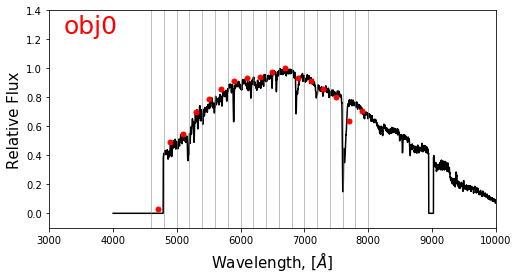

 
 >>>>>>>>>> OBJ:  1  <<<<<<<<<<
     -->> Summing up Wavelength Bins


Binning.py:267: RuntimeWarning: All-NaN slice encountered
  plt.plot(wav_arr[s,10,:],cnt_arr[s,10,:]/np.nanmax(cnt_arr[s,10,:]),color='black')
Binning.py:268: RuntimeWarning: All-NaN slice encountered
  plt.plot(bin_ctr,bin_cnt[10,:,s]/np.nanmax(bin_cnt[10,:,s]),'.',markersize=10,color='red')
Binning.py:269: RuntimeWarning: All-NaN slice encountered
  plt.errorbar(bin_ctr,bin_cnt[10,:,s]/np.nanmax(bin_cnt[10,:,s]),
Binning.py:270: RuntimeWarning: All-NaN slice encountered
  yerr=10*bin_err[10,:,s]/np.nanmax(bin_cnt[10,:,s]),fmt=None,ecolor='red')


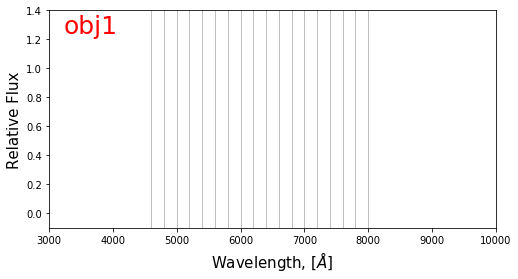

 
 >>>>>>>>>> OBJ:  2  <<<<<<<<<<
     -->> Summing up Wavelength Bins


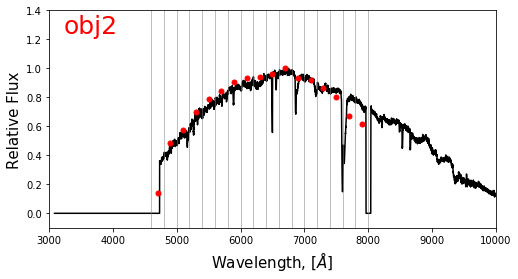

 
 >>>>>>>>>> OBJ:  3  <<<<<<<<<<
     -->> Summing up Wavelength Bins


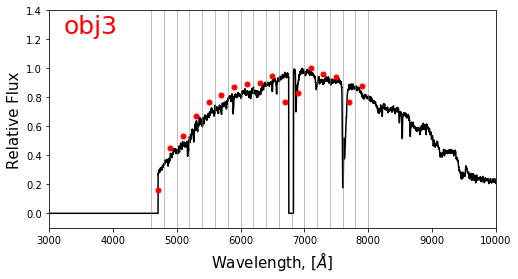

 
 >>>>>>>>>> OBJ:  4  <<<<<<<<<<
     -->> Summing up Wavelength Bins


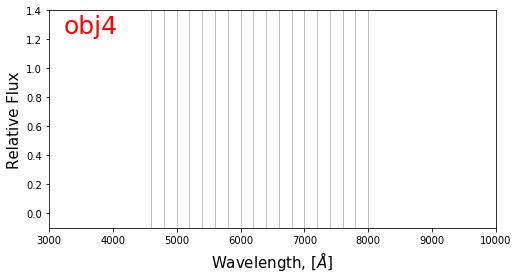

 
 >>>>>>>>>> OBJ:  5  <<<<<<<<<<
     -->> Summing up Wavelength Bins


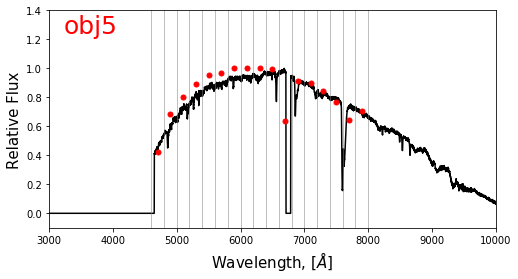

 
 >>>>>>>>>> OBJ:  6  <<<<<<<<<<
     -->> Summing up Wavelength Bins


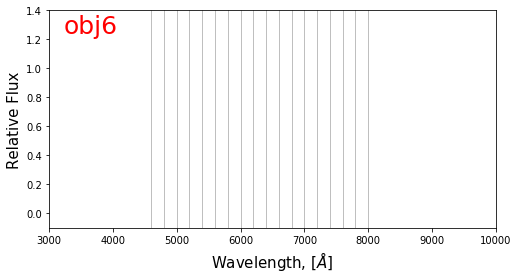

 
 >>>>>>>>>> OBJ:  7  <<<<<<<<<<
     -->> Summing up Wavelength Bins


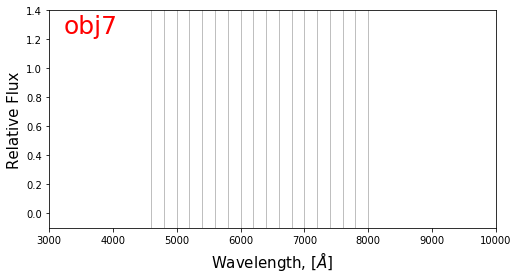

 
 >>>>>>>>>> OBJ:  8  <<<<<<<<<<
     -->> Summing up Wavelength Bins


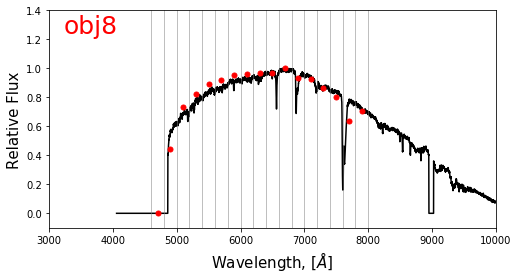

In [2]:
from Binning import BinWhite
from Binning import BinLam

#200,100,50,40,30,20,15

start=4600
end=8000
width=200

corr=False
flip=True



Test=BinWhite(SAVEPATH,midtime,start,end,flip,[],binny)
Test2=BinLam(SAVEPATH,midtime,start,end,width,flip,[],binny)

# --------------------------------------------------------------------------- 
# Generate Light Curves

The first cell takes as input the desired calibrators, as well as a check star (csn)
The second cell fits the baseline and removes it as a function of time (with specified order)

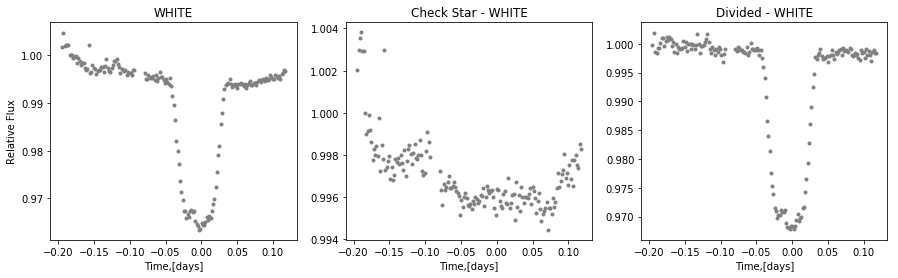

[4600. 4800. 5000. 5200. 5400. 5600. 5800. 6000. 6200. 6400. 6600. 6800.
 7000. 7200. 7400. 7600. 7800. 8000.]


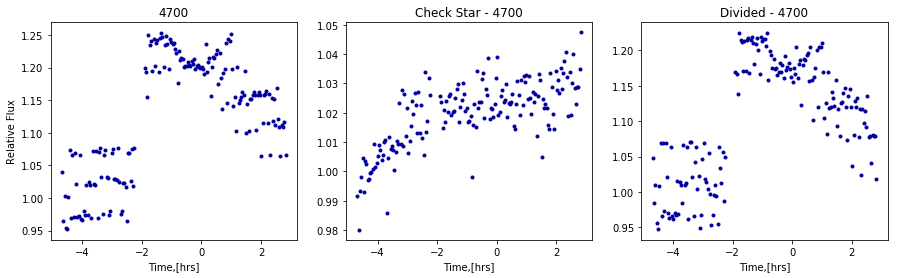

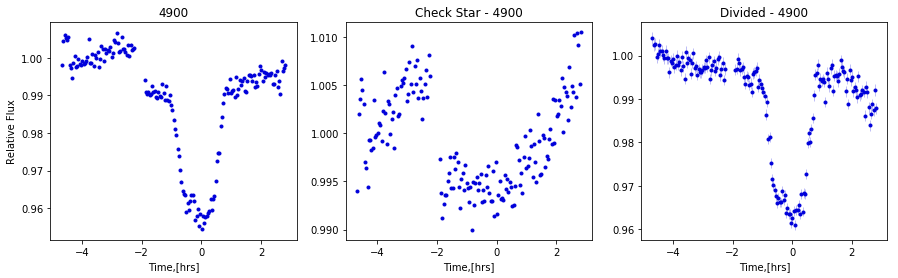

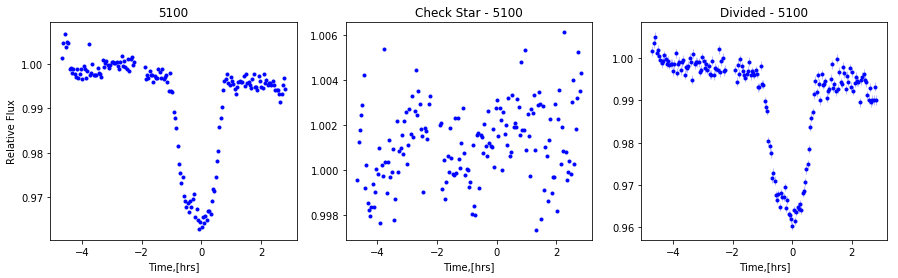

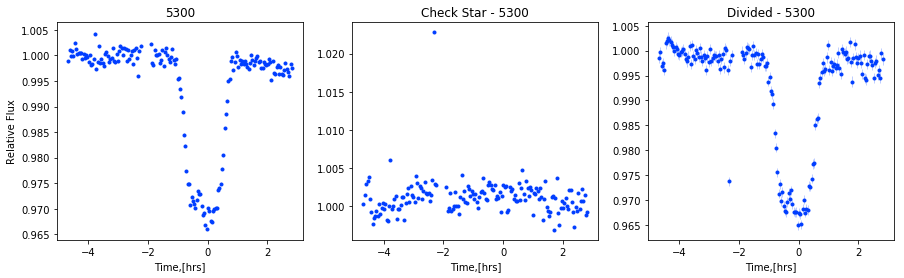

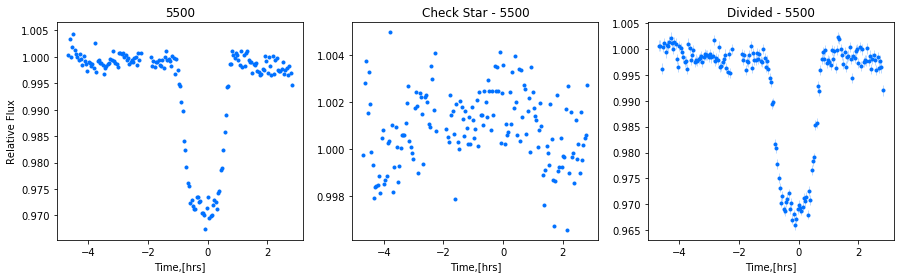

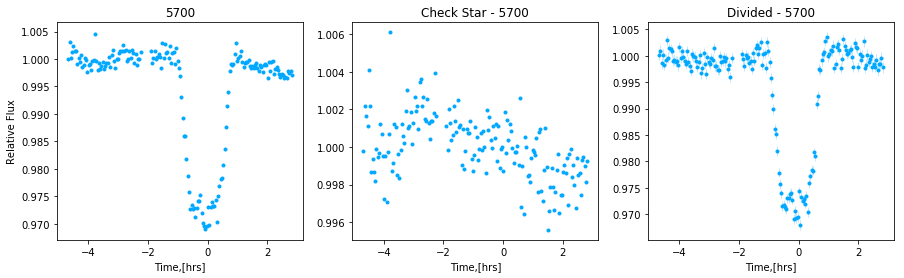

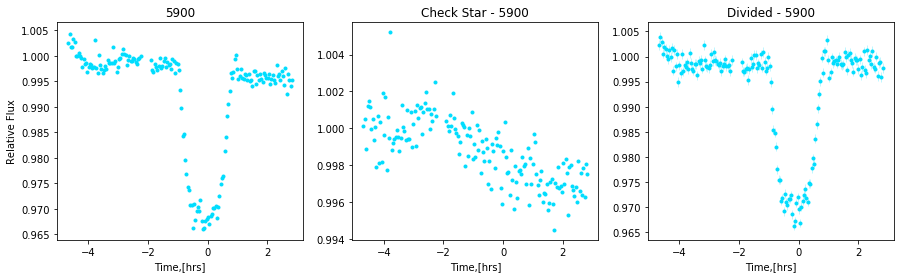

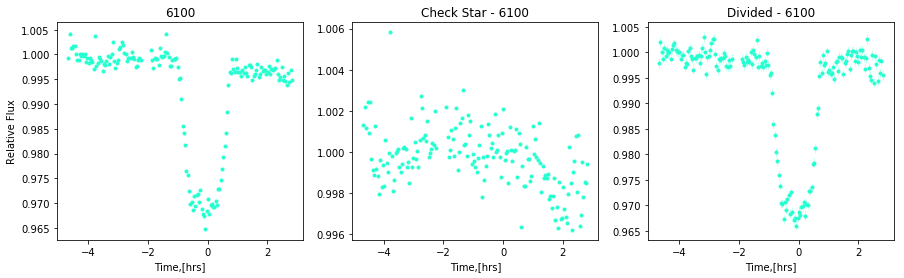

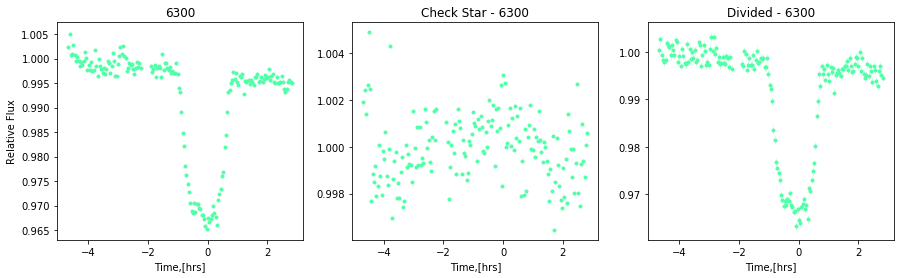

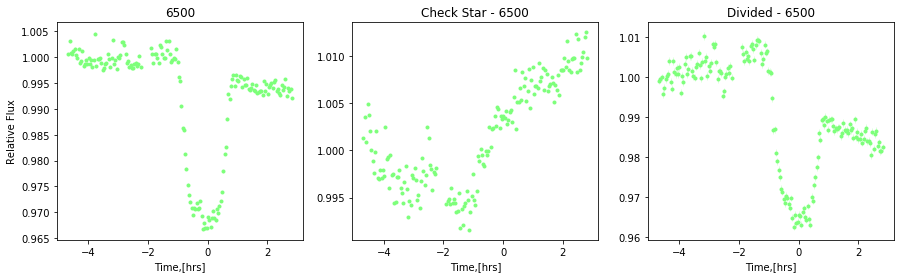

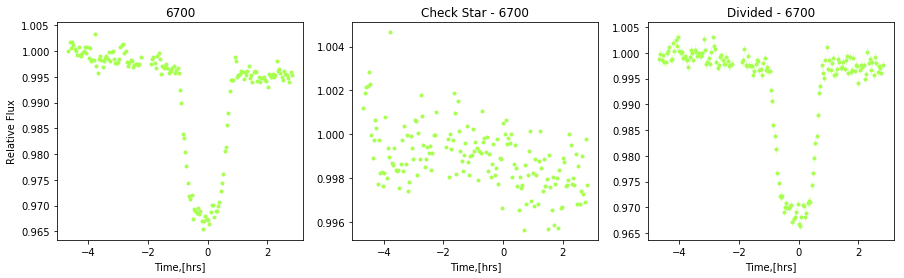

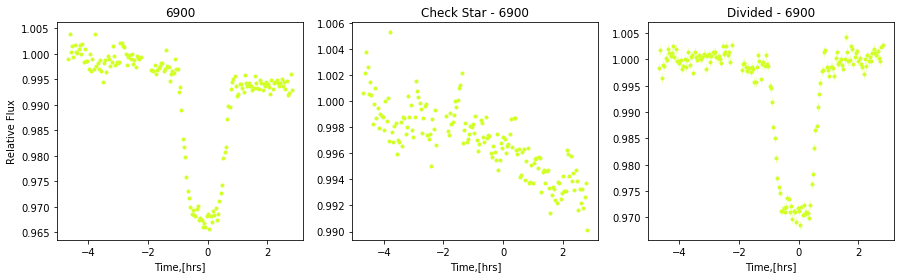

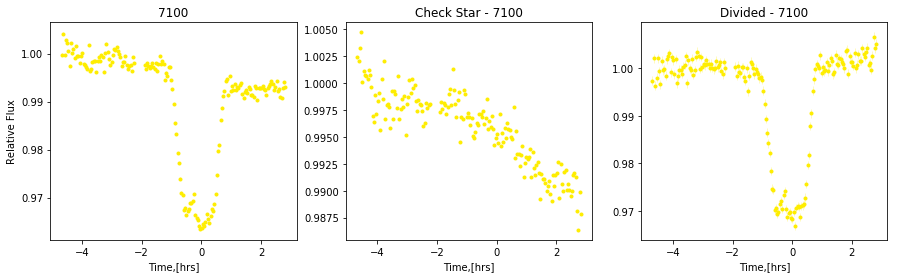

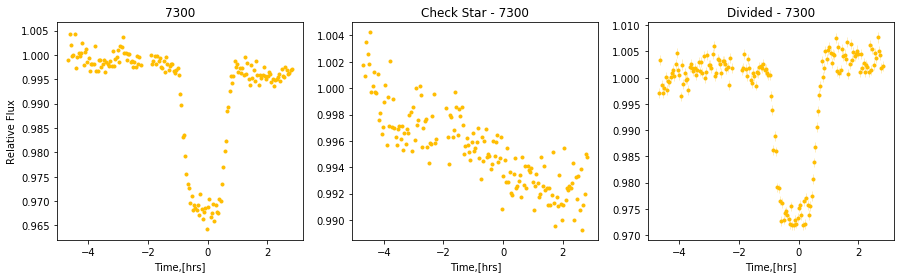

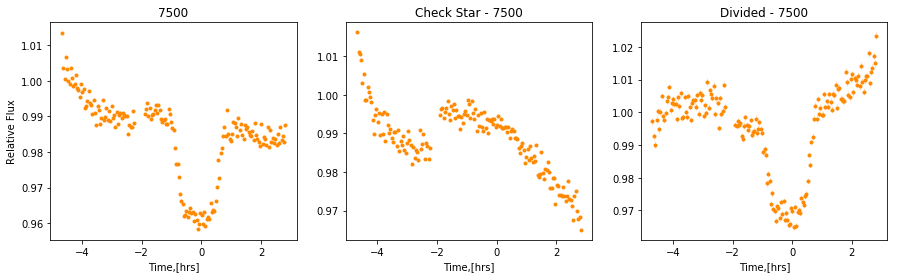

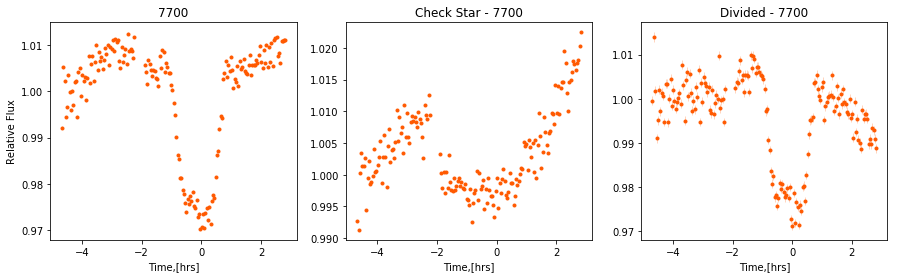

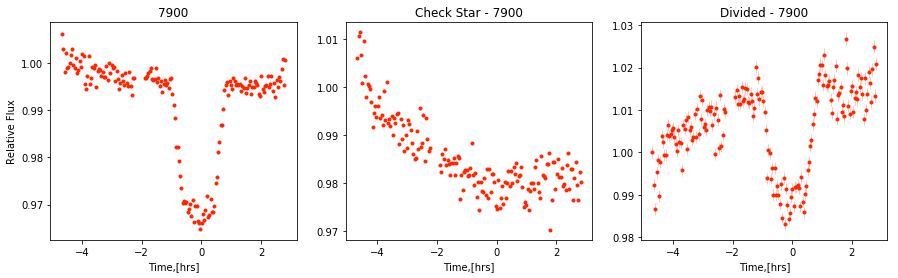

In [9]:
from GenerateLC import LCgen_binns,LCgen_white


corr=False
width=200

#Wasp52
# 1 2 3 4 5 6 7 8 
# X O ~ X ~ X X ~
# X ~ ~ X ~ X X 
Cals_ind=[2,5,8]  
csn=2

#Wasp4
#1,4,5,7,8,10,11,12
#USE: 5,
# 1 2 3 4 5 6 7 8 9 10 11 12
# X X X _ _ X X _ X  X _ _
# X X X X O X X ~ X  X  X ~
#Cals_ind=[4,5,8,11,12]
#csn=5

#HatP26b
# 1 2 3 4 5 6 7
# X ~ ~ ~ ~ X X
#Cals_ind=[2,3,4,5]
#csn=2

#Hats8
# 1  2  3  4  5  6  7
# X
#Cals_ind=[2,3,4,5,6]
#csn=2

#WD1145
# 1  2  3  4  5  6  7  8  9 10
# X  X  X  ~  X  X  X  ~  ~ X 
#Cals_ind=[2,4,8,9]
#csn=2

#Wasp 67
# 1  2  3  4  5  6  7  8  9  10
# X  X  X  X  X  ~  ~   X  X  X
#Cals_ind=[6,7]
#csn=6

white=LCgen_white(SAVEPATH,corr,Cals_ind,csn)
binns=LCgen_binns(SAVEPATH,width,corr,Cals_ind,csn)


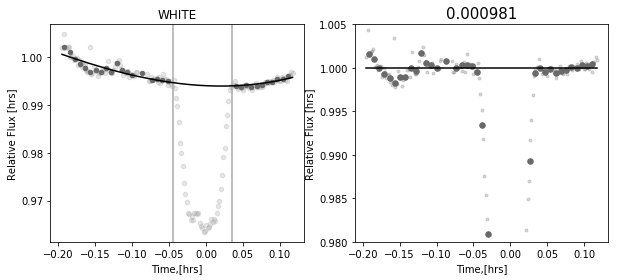

[4600. 4800. 5000. 5200. 5400. 5600. 5800. 6000. 6200. 6400. 6600. 6800.
 7000. 7200. 7400. 7600. 7800. 8000. 8200. 8400.]
(170, 17)
0


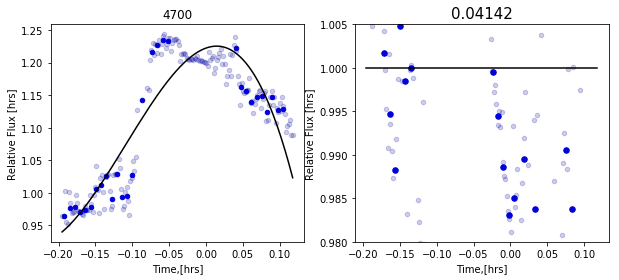

1


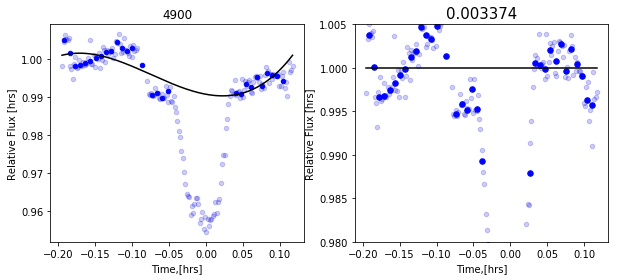

2


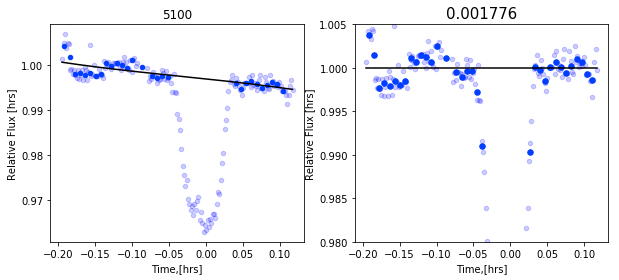

3


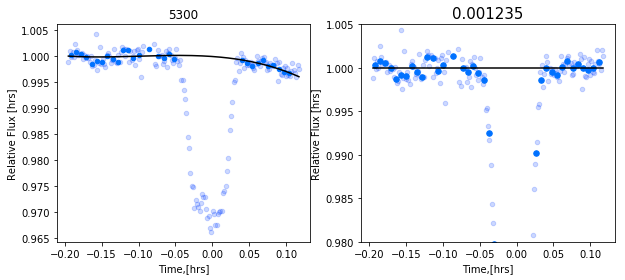

4


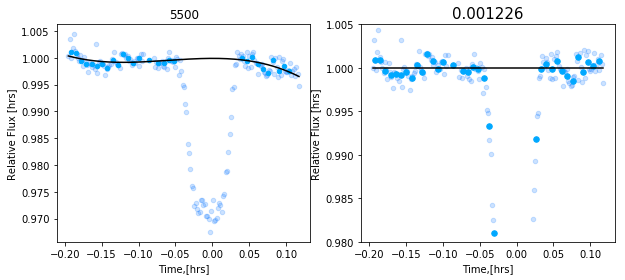

5


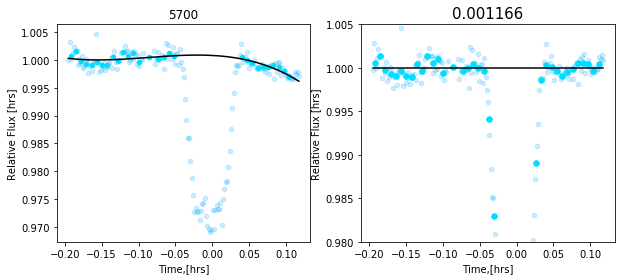

6


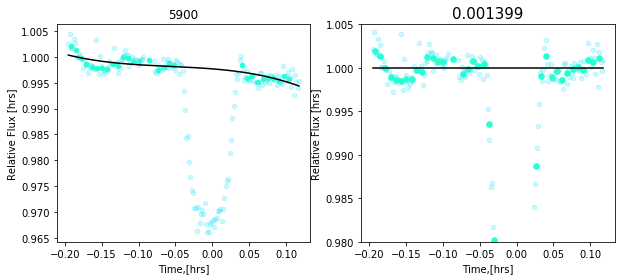

7


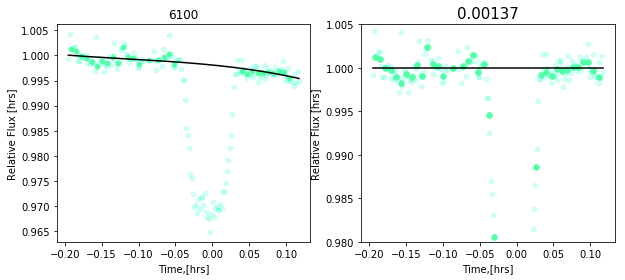

8


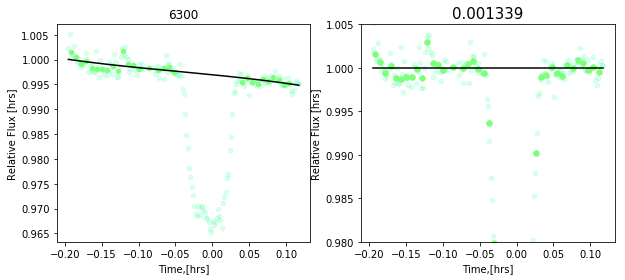

9


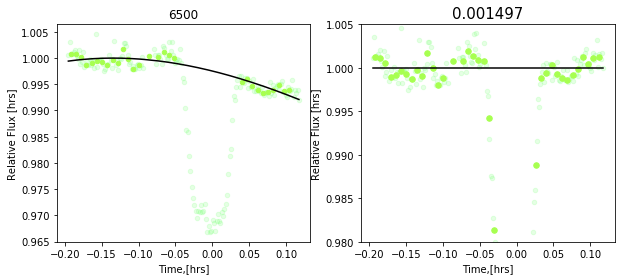

10


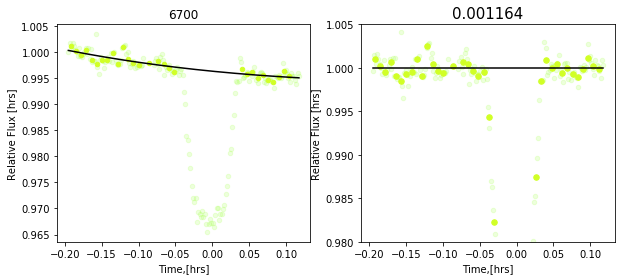

11


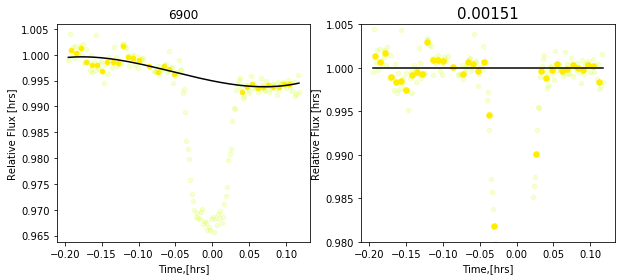

12


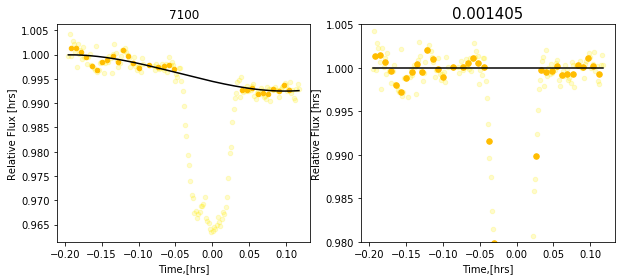

13


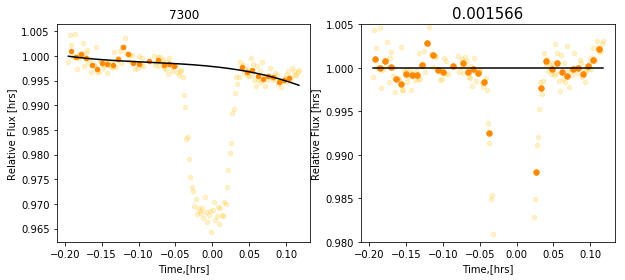

14


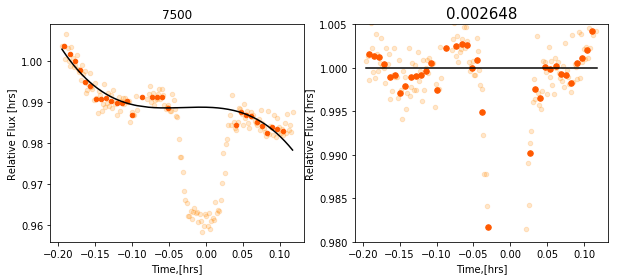

15


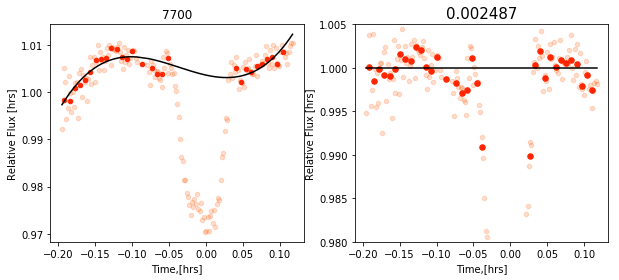

16


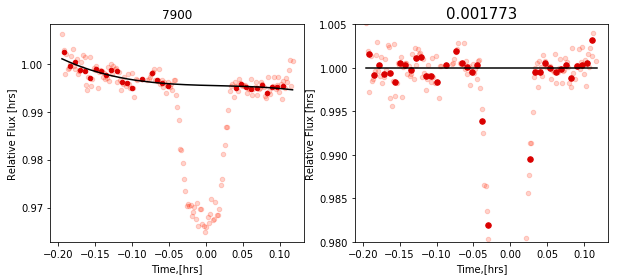

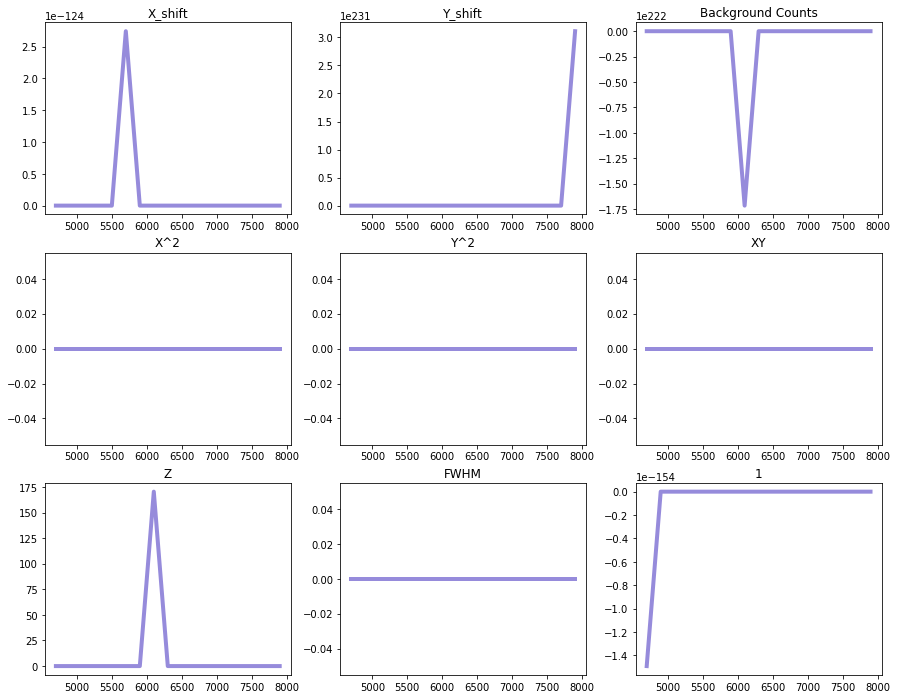

In [10]:
# Hats8 transit 1--- -0.05, 0.06
#W52 transit 1 --- -0.045, 0.035
#W52 transit 2 -- 
from BaselineFitting import blfit_binns,blfit_white

order=3         # polynomial order (in time)
avg=4          # number of points to average together
olow=0.90       # outlier - low end
ohigh=1.01      # outlier - high end
ybot=0.98       # ylim - low end (plot)
ytop=1.005       # ylim - high end (plot)

timein=-0.045
timeeg=0.035

noise_red=False  #do simple red noise removal. Run NoiseModel_prep notebook first!!!
noise_white=False  #white light noise removal

#W52: -0.045, 0.035 
#W4: -0.05,0.045
#Hats8 -0.06,0.06
#Wasp67: 

corr=False
width=200
spot=False  #if there is a spot, need to read in a different file for white light fit

h_o_t=False  # high order terms
see_t=False  # seeing term



white=blfit_white(SAVEPATH,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr,noise_red,h_o_t,see_t)
binns=blfit_binns(SAVEPATH,width,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr,noise_white,noise_red,h_o_t,see_t,spot)

# --------------------------------------------------------------------------- 
# Uses BATMAN to fit the light curves.

In [4]:
width=200
corr=False
avg=False

nwalkers=50#0
burnin=100#0
nsteps=1000#0

color=0
cont=True

In [5]:
#####################################################                                                                                           
#####################################################                                                                                           
##        Fitting of lightcurves using BATMAN      ##                                                                                           
##  ---------------------------------------------  ##                                                                                           
##  reads in .npz files from Lightcurve_Script.py  ##                                                                                           
##     See README.txt in Magellan/pipeline         ##                                                                                           
#####################################################                                                                                           
#####################################################   

import numpy as np
np.seterr(all='ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import batman

import emcee
import corner

#import astropy
#from astropy.time import Time
#import pyfits                                                                                                                                  

#import scipy
from scipy.interpolate import interp1d
#from scipy.signal import medfilt

from datetime import datetime
startTime1=datetime.now()

from outlier_removal import outlierr

import sys
print (sys.argv)
 

sys.path.insert(0,SAVEPATH) 
from SystemCons import *

print per, rp, sma

#width=200


#################################
t=np.load(SAVEPATH+'Obs_times.npz')['times']
n_exp=len(t)
fulltime=np.load(SAVEPATH+'Obs_times.npz')['times']
t_z=np.load(SAVEPATH+'LCwhite_br.npz')['avt']

if corr==True:
    if avg==True:
        t=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avt']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['avf']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['rmse']
            
    else:
        t=np.load(SAVEPATH+'Obs_times.npz')['times']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['rmse']
else:
    if avg==True:
        t=np.load(SAVEPATH+'LCwhite_br.npz')['avt']
        n_exp=len(t)
            
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['avf']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['rmse']
            
    else:   
        t=np.load(SAVEPATH+'Obs_times.npz')['times']
        n_exp=len(t)
    
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['rmse']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['rmse']
    
bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']
print lc_data_white.shape
print len(lc_data_white)

####################################################                                                                                            
norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr),vmax=np.max(bin_ctr))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

####################################################                                                                                            
#              LIMB DARKENING FUNCION              #                                                                                            
####################################################                                                                                            
# U B V R I J H K                                                                                                                               

limb_dark='quadratic'

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             

q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

####################################################                                                                                            
#              LIGHT CURVE FUNCTION                #                                                                                            
####################################################                                                                                            
def lc_func(t,t0,per,rp,a,inc,ecc,w,u,limb_dark):
    params=batman.TransitParams()
    params.t0=t0
    params.per=per
    params.rp=rp
    params.a=a
    params.inc=inc
    params.ecc=ecc
    params.w=w
    params.u=u
    params.limb_dark=limb_dark

    model=batman.TransitModel(params,t)
    return params, model

####################################################                                                                                            
#     Prior, Likelihood, Posterior Functions       #                                                                                            
####################################################                                                                                            
def loggaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

def lnprior(theta,color):
    if color==0:
        t0_f,per_f,rp_f,inc_f,c1_f,c2_f=theta
        if t0_f>t0dn and t0_f<t0up and rp_f>rpdn and rp_f<rpup and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return loggaus(per,per_e,per_f)+loggaus(inc,inc_e,inc_f)
        else:
            return -np.inf
    if color==1:
        rp_f,c1_f,c2_f=theta
        if rp_f<rpup and rp_f>rpdn and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return 0.0
        else:
            return -np.inf

def lnlike(theta,params,model,t,flux,err,color):
    if color==0:
        params.t0,params.per,params.rp,params.inc,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
        Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
        smacm=(((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.)
        params.a=smacm/Rs_s
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
    if color==1:
        params.rp,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))


def lnprob(theta,params,model,t,flux,err,color):
    prior=lnprior(theta,color)
    if not np.isfinite(prior):
        return -np.inf
    post=prior+lnlike(theta,params,model,t,flux,err,color)
    return post

####################################################                                                                                            
#     RUN MCMC CODE      #                                                                                            
####################################################   

def runmcmc(nwalkers,burnin,nsteps,pos0,params,model,time,data,error,color):
    sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2.0, args=(params,m,t,data,error,color))
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Running Burn-in...'))
                                                                                                                        
    time1=datetime.now()
    p0,test1,test2=sampler.run_mcmc(pos0,burnin)
    time2=datetime.now()
    Output.write('{0} {1} \n'.format('           Time to Run: ', time2-time1))
    sampler.reset()
                                                                                                                          

    Output.write('{0} \n'.format('     -->> Running Chain...'))
    Output.close()
    for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
        if (i+1)%(nsteps/10) ==0:
            Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
            Output.write('{0} {1} {2} \n'.format(("            {0:5.1%}".format(float(i+1) / nsteps)),'          ', datetime.now()))
            Output.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} {1} \n'.format('     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)))
    Output.close()
    
    samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))
    
    return samples

    

#####################
#nwalkers=500
#burnin=500
#nsteps=3000

Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','w')

#color=0
if color==0:
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<'))
    print('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<')
    
    print('-----------> outliers')
    lc_data_white=outlierr(lc_data_white,5,3)
    lc_data_white=outlierr(lc_data_white,5,3)
    
    #if np.nan(yerr_white)==0.0:
    #    yerr_white=np.ones_like(yerr_white)*10**-3.
    
    c1=q0_func(6000)
    c2=q1_func(6000)
    u=[c1,c2]
                                                                                                                          
    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
    initial=np.array([t0,per,rp,inc,c1,c2])
    ndim=len(initial)
    
    Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
    Output.close()

    t0_arr=np.linspace(t0dn,t0up,10**6.)
    per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
    rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
    inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
    c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
    c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

    pos0=np.empty([nwalkers,ndim])
    for i in range(nwalkers):
        pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),np.random.choice(inc_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
    runwhite=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_white,yerr_white,color)
    
    t0o,pero,rpo,inco,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runwhite, [16, 50, 84], axis=0)))
    t0,per,rp,inc,c1,c2=t0o[0],pero[0],rpo[0],inco[0],c1o[0],c2o[0]
    u=[c1,c2]
    sma=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=sma/Rs

    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    paramsp,mp=lc_func(fulltime,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    paramsz,mz=lc_func(t_z,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
    fitlightcurve=m.light_curve(params)
    fitlightcurvep=mp.light_curve(paramsp)
    fitlightcurvez=mz.light_curve(paramsz)
    
    residuals=(fitlightcurve-lc_data_white)*10**6.
    residuals=(fitlightcurvep-lc_data_white)*10**6.
    res_white=residuals
    
    chi2=np.nansum(np.abs(residuals/10**6.)**2.)

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Best Fit Params'))
    Output.write('{0} {1} {2} {3} \n'.format('          t0  : ', t0,  np.round(t0o[1],5),np.round(t0o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          per : ', per, np.round(pero[1],10),np.round(pero[2],10)))
    Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
    Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
    Output.write('{0} {1} {2} {3} \n'.format('          inc : ', inc, np.round(inco[1],5),np.round(inco[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
    Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
    Output.close()

    plt.figure()
#    plt.clf()                                                                                                                                  
    plt.plot(t,lc_data_white,'.',markersize=10,markeredgecolor='black',markerfacecolor='grey')
    plt.plot(fulltime,fitlightcurvep,'-',color='black')
    plt.ylim(0.96,1.01)
    plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
#    plt.figtext(0.55,0.60, str(int(bin_wav[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_wav[b]))                                         
    plt.figtext(0.55,0.80, 'White Light', fontsize=25,color='grey')
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_white.png')
    plt.close()

    t0min=np.max([t0dn,t0-5*t0o[2]])
    t0max=np.min([t0up,t0+5*t0o[1]])
    rpmin=np.max([rpdn,rp-5*rpo[2]])
    rpmax=np.min([rpup,rp+5*rpo[1]])
    
    plt.clf()
    corner.corner(runwhite,labels=['t0','per','rp','inc','c1','c2'],truths=[t0,per,rp,inc,c1,c2],range=([t0min,t0max],[per-5*pero[2],per+5*pero[1]],[rpmin,rpmax],[inc-5*inco[2],inc+5*inco[1]],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_white.png')
    plt.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format(' '))
    Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
    Output.write('{0}\n'.format(' '))
    Output.close()

    params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
    paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

    np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_white.npz',results=runwhite,params=params,paramserr=paramserr,
                        lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurvez,residuals=residuals)
    
    if cont==True:
        color=1

if color==1:
    for b in range(0,len(bin_ctr)):
        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} {1} {2}\n'.format('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<'))
        print('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<')
        if np.isnan(lc_data_binns[0,b]):
            continue
        
        print('-----------> outliers')
        lc_data_binns[:,b]=outlierr(lc_data_binns[:,b],5,3)
        lc_data_binns[:,b]=outlierr(lc_data_binns[:,b],5,3)
                
        #lc_data_binns[:,b]=lc_data_binns[:,b]+res_white*10**-6
        
#        Output.write('{0} {1} \n'.format(' -->> WAVLENGTH CENTER = ', bin_ctr[b]))
    

        #if np.nanmax(yerr_binns[:,b])==0.0:
        #    hold=np.ones_like(yerr_binns[:,b])*10**-3.
        #    yerr_binns[:,b]=hold
    
        c1=q0_func(bin_ctr[b])
        c2=q1_func(bin_ctr[b])
        u=[c1,c2]
                                                                                                                          
        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
        initial=np.array([rp,c1,c2])
        ndim=len(initial)
    
        Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
        Output.close()

        rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
        c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
        c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

        pos0=np.empty([nwalkers,ndim])
        for i in range(nwalkers):
            pos0[i,:]=np.array([np.random.choice(rp_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
        runlam=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_binns[:,b],yerr_binns[b],color)
    
        rpo,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runlam, [16, 50, 84], axis=0)))
        rp,c1,c2=rpo[0],c1o[0],c2o[0]
        u=[c1,c2]

        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        paramsp,mp=lc_func(fulltime,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        paramsz,mz=lc_func(t_z,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
        fitlightcurve=m.light_curve(params)
        fitlightcurvep=mp.light_curve(paramsp)
        fitlightcurvez=mz.light_curve(paramsz)
        
        residuals=(fitlightcurve-lc_data_binns[:,b])*10**6.
        chi2=np.nansum(np.abs(residuals/10**6.)**2.)/yerr_binns[b]

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} \n'.format('     -->> Best Fit Params'))
        Output.write('{0} {1} \n'.format('          t0  : ', t0))#,  np.round(t0o[1],5),np.round(t0o[2],5)))                                        
        Output.write('{0} {1} \n'.format('          per : ', per))#, np.round(pero[1],5),np.round(pero[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
        Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
        Output.write('{0} {1} \n'.format('          inc : ', inc))#, np.round(inco[1],5),np.round(inco[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
        Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
        Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
        Output.close()

        plt.figure()
#    plt.clf()                                                                                                                                  
        plt.plot(t,lc_data_binns[:,b],'.',markersize=10,markeredgecolor='black',markerfacecolor=scal_m.to_rgba(bin_ctr[b]))
        plt.plot(fulltime,fitlightcurvep,'-',color='black')
        plt.ylim(0.96,1.01)
        plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
        plt.figtext(0.55,0.80, str(int(bin_ctr[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_ctr[b]))                                         
#        plt.figtext(0.55,0.60, 'White Light', fontsize=25,color='grey')
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        rpmin=np.max([rpdn,rp-5*rpo[2]])
        rpmax=np.min([rpup,rp+5*rpo[1]])
    
        plt.clf()
        corner.corner(runlam,labels=['rp','c1','c2'],truths=[rp,c1,c2],range=([rpmin,rpmax],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0}\n'.format(' '))
        Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
        Output.write('{0}\n'.format(' '))
        Output.close()

        params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
        #paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])
        paramserr=np.array([[rpo[1],rpo[2]],[c1o[1],c1o[2]],[c2o[1],c2o[2]]])

        np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_'+str(int(bin_ctr[b]))+'.npz',results=runlam,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurvep,lcfitz=fitlightcurvez,residuals=residuals)

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
  

['/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-caa6bb0c-a8d0-4470-8749-5dd8dd73b78b.json']
1.7497798 0.15 7.38338832319
(145,)
145
>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<
-----------> outliers


/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:244: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:245: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:246: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:247: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:248: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:249: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted a

('>>>>>>>>>> WAVELENGTH BIN: ', 4100.0, ' <<<<<<<<<<')
-----------> outliers


/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:358: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:359: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:360: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


('>>>>>>>>>> WAVELENGTH BIN: ', 4300.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 4500.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 4700.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 4900.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 5100.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 5300.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 5500.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 5700.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 5900.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 6100.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 6300.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 6500.0, ' <<<<<<<<<<')
-----------> outliers
('>>>>>>>>>> WAVELENGTH BIN: ', 6700.0, ' <<<<<<<<<<')
-----------> outliers

In [12]:
import corner

In [ ]:
from LCfit import lcfit

width=200
corr=False
avg=False
nwalkers=250
burnin=200
nsteps=500
color=0   #0=white, 1=bins

white=lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,0)
binns=lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,1)


In [3]:
import sys
sys.path.insert(0,SAVEPATH) 
from SystemCons import *

print per, rp, sma
print SAVEPATH

3.583893 0.081 9.24021952675
/Volumes/ermay_ext/Magellan/ut20170723/SaveData_Hats8/


64


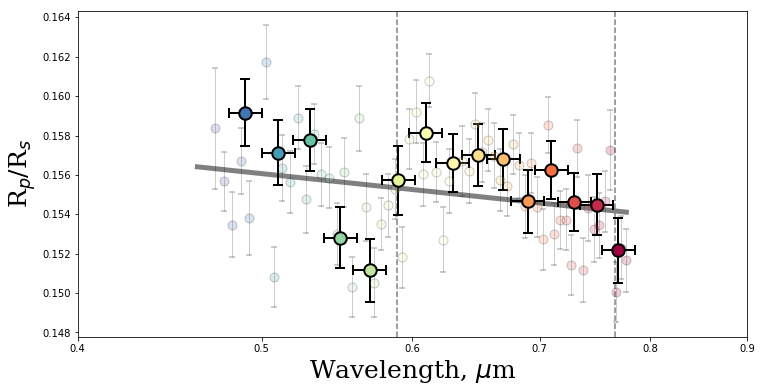

In [104]:
width=50

#mfile='HATS8b_1em1S.dat'
#model=(np.genfromtxt(SAVEPATH+mfile,usecols=[1],skip_header=2)/100)**(1./2.)
#mwave=np.genfromtxt(SAVEPATH+mfile,usecols=[0],skip_header=2)*10**10.


from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

import os

bin_ctr_200=np.load(SAVEPATH+'LC_bins_br_200.npz')['bin_ctr']
dt_e_p_200=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_200.npz')['err_p'],axis=0)
dt_e_t_200=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_200.npz')['err_t'],axis=0)
             
rp_200=np.empty([len(bin_ctr_200)])
rp_e_200=np.empty([len(bin_ctr_200)])
rs_e_200=np.empty([len(bin_ctr_200)])

bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']
dt_e_p=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_p'],axis=0)
dt_e_t=np.nanmedian(np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_t'],axis=0)
             
rp=np.empty([len(bin_ctr)])
rp_e=np.empty([len(bin_ctr)])
rs_e=np.empty([len(bin_ctr)])

norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr_200),vmax=np.max(bin_ctr_200))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

print len(bin_ctr)

b=0
for file in os.listdir(SAVEPATH+'Fits_'+str(int(width))+'/'):
    if file.endswith('.npz'):
        if b==len(bin_ctr):
            rbwhite=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['params'])[2]
        else:
            rp[b]=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['params'])[2]
            rp_e[b]=np.nanmedian((np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['paramserr'])[2])
            rs_e[b]=np.abs(np.nanmedian(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['residuals']))*10**-6
            b+=1
            
b=0
for file in os.listdir(SAVEPATH+'Fits_200/'):
    if file.endswith('.npz'):
        if b==len(bin_ctr_200):
            rbwhite_200=(np.load(SAVEPATH+'Fits_200/'+file)['params'])[2]
        else:
            rp_200[b]=(np.load(SAVEPATH+'Fits_200/'+file)['params'])[2]
            rp_e_200[b]=np.nanmedian((np.load(SAVEPATH+'Fits_200/'+file)['paramserr'])[2])
            rs_e_200[b]=np.abs(np.nanmedian(np.load(SAVEPATH+'Fits_200/'+file)['residuals']))*10**-6
            b+=1
            
owave=np.logspace(4000,9000,1000)

wavelog=np.log(bin_ctr)
test=np.polyfit(wavelog,rp,1)
test=(np.poly1d(test))(wavelog)
#tests=(np.poly1d(test))(np.log(mwave))
            
            
plt.figure(figsize=(12,6)) 
#plt.figure(figsize=(8,10.5)) #full page size
#plt.figure(figsize=(8,5.25)) #half page size

plt.plot(wavelog,test,color='grey',linewidth=5.0)
#plt.plot(np.log(mwave),model+tests-0.085,color='grey',linewidth=5.0)
#plt.plot(np.log(mwave),model,color='dimgrey',linewidth=2.0,linestyle='--')
for b in range(0,len(bin_ctr)):
    if b==0 or b==1 or b==7 or b==34:# or b==3 or b==11 or b==17:
        continue
    plt.plot(np.log(bin_ctr[b]),rp[b],'.', markeredgewidth=1.0,markersize=18,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]),alpha=0.2,zorder=11)
    plt.errorbar(np.log(bin_ctr[b]),rp[b],yerr=(rp_e[b]+rs_e[b]+dt_e_t[b]),color='black',elinewidth=1.0,capsize=3.0,capthick=2.0,alpha=0.2,zorder=10)

for b in range(0,len(bin_ctr_200)):
    if b==0:# or b==1 or b==3 or b==11 or b==17:
        continue
    plt.plot(np.log(bin_ctr_200[b]),rp_200[b],'.', markeredgewidth=2.0,markersize=25,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr_200[b]),zorder=11)
    plt.errorbar(np.log(bin_ctr_200[b]),rp_200[b],yerr=(rp_e_200[b]+rs_e_200[b]+dt_e_t_200[b]),xerr=0.02,color='black',elinewidth=2.0,capsize=5.0,capthick=2.0,zorder=10)
plt.axvline(x=np.log(5890),linestyle='--',color='grey')
plt.axvline(x=np.log(7665),linestyle='--',color='grey')

plt.xticks(np.log([4000,5000,6000,7000,8000,9000]),['0.4','0.5','0.6','0.7','0.8','0.9'])
plt.xlim(np.log(4000),np.log(9000))
#plt.ylim(0.08,0.15)  #Hats8b
#plt.ylim(0.16,0.18)
#plt.figtext(0.20,0.45,'Solar Composition Atmosphere,',fontsize=15, fontproperties=font, color='dimgrey')
#plt.figtext(0.20,0.40,'Increased Scattering Properties',fontsize=15, fontproperties=font, color='dimgrey')
#plt.figtext(0.15,0.20,'Standard Scattering Properties',fontsize=15, fontproperties=font, color='dimgrey')
#plt.annotate('Na',xy=(np.log(5900),0.13),xytext=(np.log(6000),0.145),arrowprops=dict(facecolor='black', shrink=0.01,width=1.5),fontsize=12,fontproperties=font)
#plt.annotate('K',xy=(np.log(7700),0.125),xytext=(np.log(8000),0.135),arrowprops=dict(facecolor='black', shrink=0.01,width=1.5),fontsize=12,fontproperties=font)
plt.ylabel('R$_p$/R$_s$',fontsize=25,fontproperties=font)
plt.xlabel('Wavelength, $\mu$m',fontsize=25,fontproperties=font)
#plt.show()
plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/TSpec.pdf')        

In [117]:
print rp
print rp_e

[ 0.15949483  0.15954306  0.15694375  0.1612186   0.16254193  0.15875766
  0.16978811  0.17089049  0.16582143  0.16969894  0.16081915  0.15677936
  0.16080465  0.16815951  0.17127783  0.16324317]
[ 0.02706086  0.01415127  0.01353614  0.0122257   0.01187644  0.01267135
  0.01136422  0.01093413  0.01151341  0.01260789  0.01240517  0.01209345
  0.01197567  0.01083277  0.01253746  0.01287247]


16
[ 4600.  4800.  5000.  5200.  5400.  5600.  5800.  6000.  6200.  6400.
  6600.  6800.  7000.  7200.  7400.  7600.  7800.  8000.  8200.]


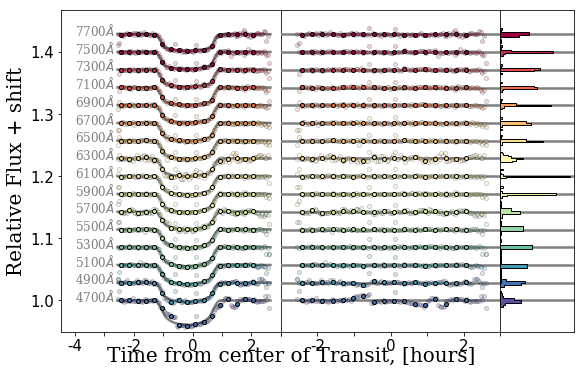

In [76]:
width=200
##############

from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

import matplotlib.gridspec as gridspec

import os
###############

lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['data']

t_z=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avt']
            
#lc_data_white_z=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avf']
lc_data_binns_z=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['avf']


bin_arr=np.load(SAVEPATH+'Binned_Data_'+str(int(width))+'.npz')['bins']
bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']
n_bins=len(bin_ctr)

print n_bins

bin_arr=np.append(bin_arr,[bin_arr[-1]+width,bin_arr[-1]+2*width])
print bin_arr

###############
norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr),vmax=np.max(bin_ctr))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])
################

t=np.load(SAVEPATH+'Obs_times.npz')['times']
n_exp=len(t)

lc_fit=np.empty([n_exp,n_bins])
lc_fit_z=np.empty([len(t_z),n_bins])
lc_data=np.empty([n_exp,n_bins])

shift=np.linspace(0,n_bins/35., n_bins+1)

###############

b=0
for file in os.listdir(SAVEPATH+'Fits_'+str(int(width))+'/'):
    if file.endswith('.npz'):
        if b==len(bin_ctr):
            lcwhite=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['lightcurve_fit'])
        else:
            lc_fit[:,b]=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['lightcurve_fit'])
            lc_fit_z[:,b]=(np.load(SAVEPATH+'Fits_'+str(int(width))+'/'+file)['lcfitz'])
            b+=1


#plt.figure(figsize=(8.5,11))
#plt.figure(figsize=(10,7.5))
#plt.figure(figsize=(8,10.5)) #full page size
#plt.figure(figsize=(8,7.875))
plt.figure(figsize=(8,5.25)) #half page size

plt.gcf().subplots_adjust(bottom=0.1,top=0.95,left=0.1,right=0.99)
gs1=gridspec.GridSpec(1,7)
gs1.update(wspace=0.00,hspace=0.0)

ymin=0.95
ymax=1.01

p0=plt.subplot(gs1[:,:3])
for b in range(0,n_bins):
    #if b==0 or b==1:
    #    continue
    p0=plt.plot(24*t[:],lc_fit[:,b]+shift[b],'-',linewidth=2.5,color='grey',zorder=10)
    p0=plt.plot(24*t[:-1],lc_data_binns[:-1,b]+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]),zorder=11,alpha=0.2)
    p0=plt.plot(24*t_z[:-1],lc_data_binns_z[:-1,b]+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]+width),zorder=12)
    #p0=plt.errorbar(24*t[:-1],lc_data_binns[:-1,b]+shift[b],yerr=errs_l_t[:-1,b],ecolor=scal_m.to_rgba(bin_ctr[b]),elinewidth=0.5,alpha=0.7,fmt=None,zorder=11)
    p0=plt.xlim((t[0]-0.08)*24,(t[-1]+0.01)*24)
    p0=plt.ylim(ymin,ymax+shift[-1])
    p0=plt.ylabel('Relative Flux + shift',fontsize=20,fontproperties=font)
    p0=plt.yticks(fontsize=15)
    #p0=plt.xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4],['','','-4','', '-2','','0','','2','','4'],fontsize=15)
    #p0=plt.xticks([-4,-3,-2,-1,0,1,2,3,4],['-4','', '-2','','0','','2','','4'],fontsize=15)
    p1=plt.xticks([-4,-3,-2,-1,0,1,2,3],['-4','','-2','','0','','2',''],fontsize=15)
    p0=plt.annotate(str(int(bin_ctr[b]))+'$\AA$',xy=(-4.0,1.0+shift[b]-0.002),ha='left',fontproperties=font,color='grey',fontsize=12)
    
residuals=lc_data_binns-lc_fit
residuals_z=lc_data_binns_z-lc_fit_z

p1=plt.subplot(gs1[:,3:6])
for b in range(0,n_bins):
    #if b==0 or b==1:
    #    continue
    p1=plt.axhline(y=np.nanmean((residuals[:-1,b])+shift[b]),color='grey',linewidth=2.5,zorder=10)
    p1=plt.plot(24*t[:-1],(residuals[:-1,b])+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]),zorder=11,alpha=0.2)
    p1=plt.plot(24*t_z[:-1],(residuals_z[:-1,b])+shift[b],'.',markeredgewidth=1.0,markersize=8,markeredgecolor='black', markerfacecolor=scal_m.to_rgba(bin_ctr[b]+width),zorder=12)
    #p1=plt.errorbar(24*t[:-1],(residuals[:-1,b])+shift[b],yerr=errs_l_t[:-1,b],ecolor=scal_m.to_rgba(bin_ctr[b]),elinewidth=0.5,alpha=0.7,fmt=None,zorder=11)
    p1=plt.yticks([],[])
    p1=plt.xticks([-3,-2,-1,0,1,2,3],['','-2','','0','','2',''],fontsize=15)
    p1=plt.ylim(ymin-1.0,ymax-1.0+shift[-1])

p2=plt.subplot(gs1[:,6])
for b in range(0,n_bins):
    #if b==0 or b==1:
    #    continue
    finite=residuals[np.isfinite(residuals[:,b]),b]
    p2=plt.axhline(y=np.nanmean((residuals[:-1,b])+shift[b]),color='grey',linewidth=2.5,zorder=10)
    p2=plt.hist((finite[:-1]+shift[b]),bins=7,orientation='horizontal',histtype='stepfilled',edgecolor='black',facecolor=scal_m.to_rgba(bin_ctr[b]),normed=True,zorder=11)
    p2=plt.ylim(ymin-1.0,ymax-1.0+shift[-1])
    p2=plt.yticks([],[])
    p2=plt.xticks([],[])
#plt.ylim(0.98,1.01+shift[-1])

plt.figtext(0.5,0.02,'Time from center of Transit, [hours]', fontsize=20, ha='center',fontproperties=font)
plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/all_lcs_err_pp.pdf')    

In [26]:
head=np.load(SAVEPATH+'HeaderData.npz')
airmass=head['airmass']
obs_times=head['obs_times']
ion_pump=head['ion_pump']
elc_noise=head['elc_noise']
ccd_temp=head['ccd_temp']
RA=head['RA']
Angle_e=head['Angle_e']
n_exp=head['n_exp']
stc_temp=head['stc_temp']
DEC=head['DEC']
Angle_o=head['Angle_o']

hrs=np.load(SAVEPATH+'Obs_times.npz')['times']

np.savez(SAVEPATH+'HeaderData_ML.npz',ne=n_exp,am=airmass,ot=time0,en=elc_noise,RA=RA,DC=DEC,ct=ccd_temp,st=stc_temp,ae=Angle_e,ao=Angle_o,ip=ion_pump)

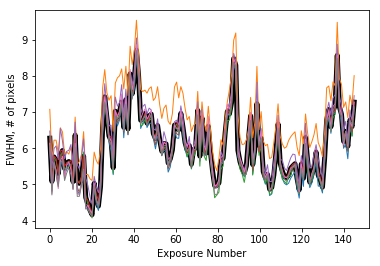

In [40]:
n_obj=9
n_exp=145

fwhm_a=np.empty([n_obj,n_exp])
bg_a=np.empty([n_obj,n_exp])

platescale=0.2  #arcseconds per pixel
for i in range(0,n_obj):
    params=np.load(SAVEPATH+'SpectraFitParams_'+str(int(i))+'.npz')
    fwhm=params['fwhm']
    xpix=params['x']
    bg=params['bg'][1]
    fwhm_av=params['fwhm_av']

    fwhm_a[i,:]=fwhm_av
    bg_a[i,:]=np.nanmedian(bg,axis=1)
    

fwhm_m=np.nanmedian(fwhm_a,axis=0)
bg_m=np.nanmedian(bg_a,axis=0)

#print fwhm_m
#print bg_m

plt.plot(np.linspace(0,n_exp,n_exp),fwhm_m,color='black',linewidth=5,zorder=0)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[0,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[1,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[2,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[3,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[4,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[5,:],linewidth=1)
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[6,:],linewidth=1)
#plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[7,:])
plt.plot(np.linspace(0,n_exp,n_exp),fwhm_a[8,:],linewidth=1)
plt.ylabel('FWHM, # of pixels')
plt.xlabel('Exposure Number')
np.savez(SAVEPATH+'MedianFWHM.npz',fwhm=fwhm_m)

In [142]:
print errs_lcd_l_t[:,b]

[ 0.06188138  0.05605862  0.05852074  0.05865679  0.05827714  0.05777156
  0.05757962  0.05711648  0.05673258  0.05718997  0.05656756  0.05562569
  0.05636685  0.05569373  0.05514685  0.05600854  0.05563509  0.055763
  0.05491142  0.05481608  0.0544028   0.05391316  0.05330822  0.05305431
  0.05216543  0.05174717  0.05207655  0.0515003   0.05146683  0.05045672
  0.05104698  0.05066949  0.05096522  0.05098242  0.05029312  0.05118117
  0.05066683  0.05067776  0.05047189  0.05041241  0.0501543   0.04970376
  0.05005724  0.05015761  0.05032557  0.05005356  0.05014247  0.04995878
  0.0504389   0.05017348  0.04931016  0.05046851  0.05057645  0.05103996
  0.05027329  0.05204772  0.0518143   0.05210593  0.05217547  0.05215215
  0.0520535   0.05189675  0.05204079  0.05197475  0.05135046  0.05234536
  0.0518983   0.05235387  0.05186407  0.05224792  0.052801    0.05195641
  0.05199648  0.05180431  0.0519238   0.05182131  0.0519745   0.05190524
  0.05209023  0.05326169  0.05286266  0.05179399  0.0

In [1]:
print int(6.2)
print int(6.8)

6
6


# --------------------------------------------------------------------------- 
# Cosmic Ray/Outlier Correction #

https://arxiv.org/pdf/1310.0083.pdf

(note, runs from exposure 3 through n_exp-2)


In [ ]:
from Outlier import medcalc,Outlier

f=5                                                               #Cut-off (pixels over f std-devs from median)

n_obj=int(np.load(SAVEPATH+'FinalMasks.npz')['masks'].shape[0])
for i in range(0,n_obj):
    Outlier(i,f,SAVEPATH)
    

In [6]:
obstimes=np.load(SAVEPATH+'Obs_times.npz') 
print obstimes.files
time=obstimes['times']
print time.shape
print time[1:-1].shape
np.savez_compressed(SAVEPATH+'Obs_times.npz',times=time[1:-1])

['times']
(145,)
(143,)


In [15]:
test=np.load(SAVEPATH+'output_arrays_0.npz')
print test.files
data=test['Y']
print data.shape
print ' '

tests=np.load(SAVEPATH+'outlier_adjusted_fluxes.npz')
print tests.files
datas=tests['Y']
print datas.shape
print ' '

test2=np.load(SAVEPATH+'MachineLearing_Inputs.npz')
print test2.files
wave=test2['wave']
print wave.shape

waves=np.zeros_like(data)
for o in range(0,data.shape[0]):
    for t in range(0,data.shape[1]):
        waves[o,t,:]=wave
   
    
np.savez_compressed(SAVEPATH+'ShiftedSpec_All.npz',data=datas,wave=waves)

['Y', 'poly_rmses', 'svr_rmses', 'el_rmses', 'ridge_rmses', 'lasso_rmses', 'poly_preds', 'svr_preds', 'el_preds', 'ridge_preds', 'lasso_preds']
(9, 143, 4749)
 
['Y']
(9, 143, 4749)
 
['bkgd', 'yshift', 'data', 'gaus', 'wave', 'phte', 'fwhm']
(4749,)
